In [1]:
import os

# This checks the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"Directory: {dirname}")
    if len(filenames) > 0:
        print(f"Found {len(filenames)} files. First one: {filenames[0]}")
        break

Directory: /kaggle/input
Directory: /kaggle/input/battery-mangaement-system
Found 2 files. First one: PK35.mat


In [2]:
import os
print("Current working directory:", os.getcwd())
print("Contents of /kaggle/input/kaggle-bms-data:")
print(os.listdir("/kaggle/input/kaggle-bms-data")[:5])

Current working directory: /kaggle/working
Contents of /kaggle/input/kaggle-bms-data:
['Cell 2 Measurements - Twelfth Photovoltaic Load Clear - GC discharge.csv', 'Cell 6 Measurements - Seventh Photovoltaic Load Cloudy - C20 discharge.csv', 'Cell 4 Measurements - Fourth Load-C20 discharge.csv', 'Cell 1 Measurements - Eleventh Load - GC discharge.csv', 'Cell 5 Measurements - Fourteenth Load - Discharge Pulses.csv']


In [3]:
import pandas as pd
import os
import re
from pathlib import Path
import numpy as np
from datetime import datetime

class BMSDataProcessor:
    """Battery Management System Data Processing Pipeline"""
    
    def __init__(self, data_directory):
        self.data_directory = Path(data_directory)
        self.master_df = None
        # Pattern to extract Cell ID and Test Condition
        self.file_pattern = r'Cell\s+(\d+)\s+Measurements\s+-\s+(.+)\.csv'
        
    def extract_metadata_from_filename(self, filename):
        match = re.search(self.file_pattern, filename, re.IGNORECASE)
        if match:
            cell_id = int(match.group(1))
            test_condition = match.group(2).strip()
            return cell_id, test_condition
        return None, None
    
    def clean_numeric_column(self, df, column_name):
        if column_name not in df.columns:
            return None
        
        # Handle comma decimal separators (European format)
        cleaned = df[column_name].astype(str).str.replace(',', '.')
        # Remove any whitespace
        cleaned = cleaned.str.strip()
        # Convert to numeric, coercing errors to NaN
        return pd.to_numeric(cleaned, errors='coerce')
    
    def normalize_column_names(self, df):
        """
        Normalize column names using regex to create consistent column names across all files
        
        Parameters:
        -----------
        df : DataFrame
            Input dataframe with raw column names
            
        Returns:
        --------
        DataFrame : Dataframe with normalized column names
        """
        # Create a mapping dictionary for column renaming
        column_mapping = {}
        
        for col in df.columns:
            # Skip if already processed
            if col in ['Cell_ID', 'Test_Condition', 'Timestamp']:
                continue
            
            # Drop Unnamed columns
            if col.startswith('Unnamed'):
                column_mapping[col] = None  # Mark for deletion
                continue
            
            # Normalize column name
            normalized = col
            
            # Voltage (V) - matches V1 (V), V2 (V), Vn (V), etc.
            if re.search(r'V\d*\s*\(V\)', col, re.IGNORECASE):
                normalized = 'Voltage_V'
            
            # Voltage (mV) - matches V1 (mV), V2 (mV), etc.
            elif re.search(r'V\d*\s*\(mV\)', col, re.IGNORECASE):
                normalized = 'Voltage_mV'
            
            # Temperature - matches T1 (ºC), T2 (°C), Tn (ºC), T1 (C), etc.
            elif re.search(r'T\d*\s*\([^\)]*C\)', col, re.IGNORECASE):
                normalized = 'Temperature_C'
            
            # Current - matches I (A), I1 (A), Current (A), etc.
            elif re.search(r'(I\d*\s*\(A\)|Current)', col, re.IGNORECASE):
                normalized = 'Current_A'
            
            # SOC - matches %SOC, % SOC, %SoC, % SoC, SOC, SoC
            elif re.search(r'%?\s*So?C', col, re.IGNORECASE):
                normalized = 'SOC_Percent'
            
            # Capacity - matches Ah, (Ah), Capacity Ah, etc.
            elif re.search(r'(Ah|\(Ah\)|Capacity)', col, re.IGNORECASE):
                normalized = 'Capacity_Ah'
            
            # Only add to mapping if name changed
            if normalized != col:
                column_mapping[col] = normalized
        
        # Apply renaming
        df_renamed = df.copy()
        
        # First, drop all Unnamed columns
        cols_to_drop = [col for col, new_name in column_mapping.items() if new_name is None]
        if cols_to_drop:
            df_renamed = df_renamed.drop(columns=cols_to_drop)
        
        # Then rename the rest
        rename_dict = {col: new_name for col, new_name in column_mapping.items() if new_name is not None}
        if rename_dict:
            df_renamed = df_renamed.rename(columns=rename_dict)
        
        return df_renamed
    
    def process_single_file(self, filepath):
        try:
            # Extract metadata from filename
            cell_id, test_condition = self.extract_metadata_from_filename(filepath.name)
            
            if cell_id is None:
                # Fallback: if filename pattern fails, try simpler check or skip
                # For this dataset, we know they start with "Cell X"
                if "Cell 1" in filepath.name: cell_id = 1
                elif "Cell 2" in filepath.name: cell_id = 2
                elif "Cell 3" in filepath.name: cell_id = 3
                elif "Cell 4" in filepath.name: cell_id = 4
                elif "Cell 5" in filepath.name: cell_id = 5
                elif "Cell 6" in filepath.name: cell_id = 6
                test_condition = filepath.stem # Use full filename as fallback condition
            
            # Read CSV with semicolon delimiter and Latin-1 encoding
            df = pd.read_csv(filepath, sep=';', encoding='latin1', 
                           on_bad_lines='warn', engine='python')
            
            # Normalize column names using regex
            df = self.normalize_column_names(df)
            
            # Add metadata columns
            df['Cell_ID'] = cell_id
            df['Test_Condition'] = test_condition
            
            # Convert timestamp to datetime with European format (day first)
            if 'Timestamp' in df.columns:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', dayfirst=True)
            
            # Clean numeric columns - now using standardized names
            numeric_columns = ['Voltage_V', 'Voltage_mV', 'Temperature_C', 'Current_A', 'SOC_Percent', 'Capacity_Ah']
            
            for col in numeric_columns:
                if col in df.columns:
                    df[col] = self.clean_numeric_column(df, col)
            
            # Remove any completely empty rows
            df = df.dropna(how='all')
            
            # Remove any completely empty columns
            df = df.dropna(axis=1, how='all')
            
            print(f"✓ Processed {filepath.name[:50]}... | Cell {cell_id} | Columns: {len(df.columns)}")
            return df
            
        except Exception as e:
            print(f"❌ Error processing {filepath.name}: {str(e)}")
            import traceback
            traceback.print_exc()
            return None
    
    def batch_load_and_merge(self):
        print(f"\n{'='*70}")
        print(f"BMS Data Processing Pipeline")
        print(f"{'='*70}\n")
        print(f"📂 Scanning directory: {self.data_directory}")
        print(f"📂 Directory exists: {self.data_directory.exists()}")
        print(f"📂 Is directory: {self.data_directory.is_dir()}")
        
        # Find all CSV files
        csv_files = list(self.data_directory.glob('*.csv'))
        print(f"🔍 Glob pattern '*.csv' found: {len(csv_files)} files")
        
        if not csv_files:
            print("⚠️  No CSV files found in directory!")
            return None
        
        print(f"📄 Found {len(csv_files)} CSV file(s)\n")
        
        # Process each file
        dataframes = []
        for filepath in csv_files:
            df = self.process_single_file(filepath)
            if df is not None:
                dataframes.append(df)
        
        if not dataframes:
            print("\n❌ No files were successfully processed!")
            return None
        
        # Merge all dataframes
        print(f"\n{'='*70}")
        print("🔗 Merging all dataframes...")
        self.master_df = pd.concat(dataframes, ignore_index=True)
        
        # Sort by Cell_ID and Timestamp
        if 'Timestamp' in self.master_df.columns:
            self.master_df = self.master_df.sort_values(['Cell_ID', 'Timestamp'])
        else:
            self.master_df = self.master_df.sort_values('Cell_ID')
        
        self.master_df = self.master_df.reset_index(drop=True)
        return self.master_df
    
    def generate_summary(self):
        if self.master_df is None: 
            print("No data to summarize!")
            return
        
        print(f"{'='*70}")
        print("📊 MASTER DATAFRAME SUMMARY")
        print(f"{'='*70}\n")
        
        print(f"Total Rows: {len(self.master_df):,}")
        print(f"Total Columns: {len(self.master_df.columns)}")
        print(f"Memory Usage: {self.master_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")
        
        print("Columns:")
        for col in self.master_df.columns:
            print(f"  - {col} ({self.master_df[col].dtype})")
        
        print(f"\n{'='*70}")
        print("Cell Distribution:")
        print(f"{'='*70}")
        cell_counts = self.master_df['Cell_ID'].value_counts().sort_index()
        for cell_id, count in cell_counts.items():
            print(f"  Cell {cell_id}: {count:,} rows")
        
        print(f"\n{'='*70}")
        print("Test Condition Distribution:")
        print(f"{'='*70}")
        test_counts = self.master_df['Test_Condition'].value_counts()
        for test, count in test_counts.items():
            print(f"  {test}: {count:,} rows")
        
        # Data quality metrics
        print(f"\n{'='*70}")
        print("Data Quality Metrics:")
        print(f"{'='*70}")
        
        numeric_cols = self.master_df.select_dtypes(include=[np.number]).columns
        missing_found = False
        for col in numeric_cols:
            missing = self.master_df[col].isna().sum()
            missing_pct = (missing / len(self.master_df)) * 100
            if missing > 0:
                print(f"  {col}: {missing:,} missing values ({missing_pct:.2f}%)")
                missing_found = True
        
        if not missing_found:
            print("  No missing values found in numeric columns!")
        
        print(f"\n{'='*70}")
        print("Sample Data (First 5 rows):")
        print(f"{'='*70}")
        print(self.master_df.head())

    def save_master_file(self, output_path='processed_bms_data.csv'):
        if self.master_df is None: 
            print("No data to save!")
            return
        
        try:
            self.master_df.to_csv(output_path, index=False)
            file_size = os.path.getsize(output_path) / 1024**2
            print(f"\n{'='*70}")
            print(f"💾 Master file saved successfully!")
            print(f"{'='*70}")
            print(f"  Location: {output_path}")
            print(f"  Size: {file_size:.2f} MB")
            print(f"  Rows: {len(self.master_df):,}")
        except Exception as e:
            print(f"❌ Error saving file: {str(e)}")


# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # Kaggle Input Path
    DATA_DIRECTORY = "/kaggle/input/kaggle-bms-data"
    
    # Initialize processor
    processor = BMSDataProcessor(DATA_DIRECTORY)
    
    # Batch load and merge all files
    master_df = processor.batch_load_and_merge()
    
    # Generate summary
    if master_df is not None:
        processor.generate_summary()
        
        # Save master file to the Kaggle "Working" directory
        processor.save_master_file('processed_bms_data.csv')
        
        print(f"\n{'='*70}")
        print("✅ Processing Complete!")
        print(f"{'='*70}\n")
        print("Next steps for ML modeling:")
        print("  1. Handle missing values (imputation or removal)")
        print("  2. Feature engineering (time-based features, rolling statistics)")
        print("  3. Train-test split (consider temporal split for time-series)")
        print("  4. Model selection (Random Forest, XGBoost, LSTM for SOC/Life prediction)")
    else:
        print("\n❌ Processing failed. Please check error messages above.")


BMS Data Processing Pipeline

📂 Scanning directory: /kaggle/input/kaggle-bms-data
📂 Directory exists: True
📂 Is directory: True
🔍 Glob pattern '*.csv' found: 110 files
📄 Found 110 CSV file(s)

✓ Processed Cell 2 Measurements - Twelfth Photovoltaic Load Cl... | Cell 2 | Columns: 8
✓ Processed Cell 6 Measurements - Seventh Photovoltaic Load Cl... | Cell 6 | Columns: 8
✓ Processed Cell 4 Measurements - Fourth Load-C20 discharge.cs... | Cell 4 | Columns: 8
✓ Processed Cell 1 Measurements - Eleventh Load - GC discharge... | Cell 1 | Columns: 8
✓ Processed Cell 5 Measurements - Fourteenth Load - Discharge ... | Cell 5 | Columns: 8
✓ Processed Cell 2 Measurements - Twelfth Photovoltaic Load Cl... | Cell 2 | Columns: 8
✓ Processed Cell 4 Measurements - Twelfth Photovoltaic Load Cl... | Cell 4 | Columns: 8
✓ Processed Cell 2 Measurements - Fifth Load-C10 discharge.csv... | Cell 2 | Columns: 8
✓ Processed Cell 1 Measurements - Ninth and Tenth Photovoltaic... | Cell 1 | Columns: 8
✓ Processed Ce

Loading processed BMS data...
Total rows loaded: 602,503

Available cells: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Test conditions available:
  - First Charge-C20 discharge
  - Second Charge-C20 discharge
  - Third Charge-C20 discharge
  - Fourth Load-C20 discharge
  - Fifth Load-C10 discharge
  - Sixth Load-C10 discharge
  - Seventh and Eighth Photovoltaic Load clear - C20 discharge
  - Seventh and Eighth Photovoltaic Load Cloudy - C20 discharge
  - Ninth and Tenth Photovoltaic Load clear - C10 discharge
  - Ninth and Tenth Photovoltaic Load Cloudy - C10 discharge
  - Eleventh Load - GC discharge
  - Twelfth Photovoltaic Load Cloudy - GC discharge
  - Twelfth Photovoltaic Load cleared - GC discharge
  - Thirteenth Load wind energy - GC discharge
  - Fourteenth Load - Discharge Pulses
  - Seventh Photovoltaic Load clear - C20 discharge
  - Seventh Photovoltaic Load Cloudy - C20 discharge
  - Eighth Photovoltaic Load Cloudy - C20 discharge
  - Eig

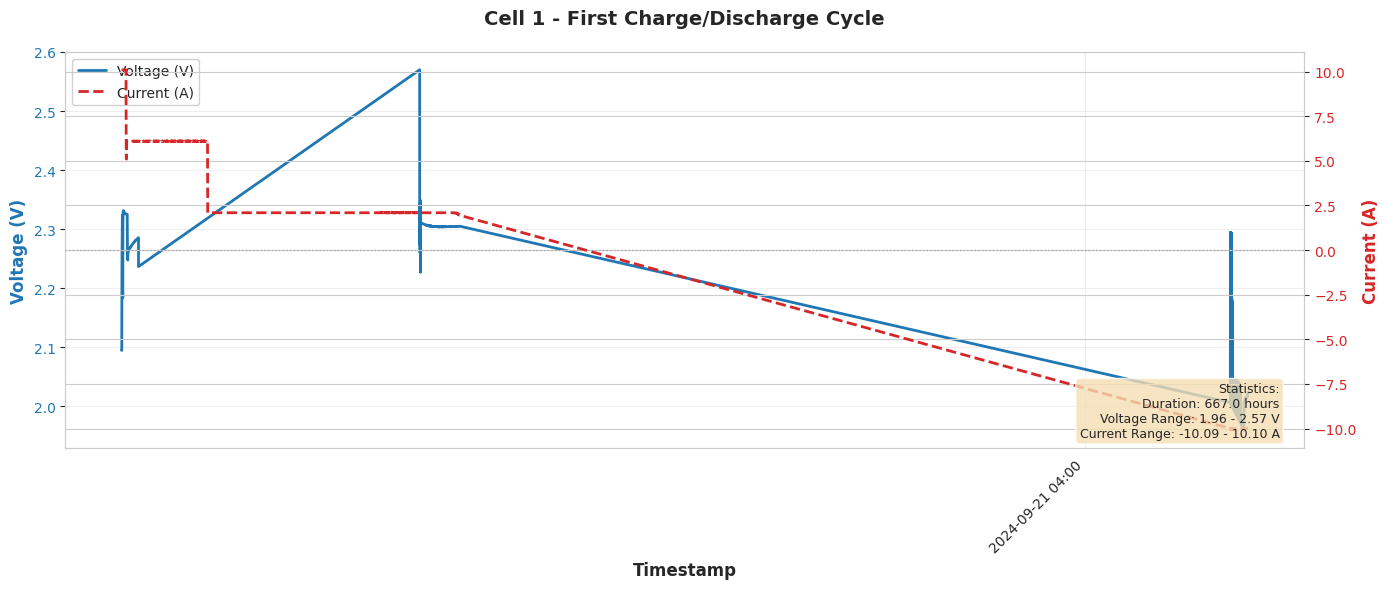


Data Quality Summary:
Missing Voltage values: 0
Missing Current values: 0

Voltage Statistics:
count    13385.000000
mean         2.348710
std          0.143776
min          1.959320
25%          2.289090
50%          2.346560
75%          2.458140
max          2.569820
Name: Voltage_V, dtype: float64

Current Statistics:
count    13385.000000
mean         1.830483
std          4.350042
min        -10.090000
25%          2.090000
50%          2.090000
75%          2.100000
max         10.100000
Name: Current_A, dtype: float64

Phase Analysis:
Charging phase data points: 12,034
  Voltage during charge: 2.09 → 2.57 V
  Average charge current: 3.16 A

Discharging phase data points: 1,351
  Voltage during discharge: 2.29 → 1.96 V
  Average discharge current: -10.00 A

✅ Physical Behavior Check:
✓ Voltage increases during charging: True
✓ Voltage decreases during discharging: False

Data quality looks good for ML training! ✅


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Load the processed data
print("Loading processed BMS data...")
df = pd.read_csv('processed_bms_data.csv')

# Convert Timestamp to datetime if it's not already
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

print(f"Total rows loaded: {len(df):,}")
print(f"\nAvailable cells: {sorted(df['Cell_ID'].unique())}")
print(f"\nTest conditions available:")
for condition in df['Test_Condition'].unique():
    print(f"  - {condition}")

# Filter for Cell 1 and specific test condition
cell_id = 1
test_condition = 'First Charge-C20 discharge'

filtered_df = df[(df['Cell_ID'] == cell_id) & 
                 (df['Test_Condition'] == test_condition)].copy()

print(f"\n{'='*70}")
print(f"Filtering for Cell {cell_id} - {test_condition}")
print(f"{'='*70}")
print(f"Filtered rows: {len(filtered_df):,}")

if len(filtered_df) == 0:
    print("\n⚠️ No data found for the specified filter!")
    print("\nAvailable test conditions for Cell 1:")
    cell1_conditions = df[df['Cell_ID'] == 1]['Test_Condition'].unique()
    for i, cond in enumerate(cell1_conditions, 1):
        row_count = len(df[(df['Cell_ID'] == 1) & (df['Test_Condition'] == cond)])
        print(f"  {i}. {cond} ({row_count:,} rows)")
else:
    # Sort by timestamp
    filtered_df = filtered_df.sort_values('Timestamp').reset_index(drop=True)
    
    # Check for required columns
    required_cols = ['Timestamp', 'Voltage_V', 'Current_A']
    missing_cols = [col for col in required_cols if col not in filtered_df.columns]
    
    if missing_cols:
        print(f"\n⚠️ Missing columns: {missing_cols}")
        print(f"Available columns: {list(filtered_df.columns)}")
    else:
        # Create the dual-axis plot
        fig, ax1 = plt.subplots(figsize=(14, 6))
        
        # Plot Voltage on left Y-axis
        color_voltage = 'tab:blue'
        ax1.set_xlabel('Timestamp', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Voltage (V)', fontsize=12, fontweight='bold', color=color_voltage)
        line1 = ax1.plot(filtered_df['Timestamp'], filtered_df['Voltage_V'], 
                        color=color_voltage, linewidth=2, label='Voltage (V)')
        ax1.tick_params(axis='y', labelcolor=color_voltage)
        ax1.grid(True, alpha=0.3)
        
        # Create second Y-axis for Current
        ax2 = ax1.twinx()
        color_current = 'tab:red'
        ax2.set_ylabel('Current (A)', fontsize=12, fontweight='bold', color=color_current)
        line2 = ax2.plot(filtered_df['Timestamp'], filtered_df['Current_A'], 
                        color=color_current, linestyle='--', linewidth=2, label='Current (A)')
        ax2.tick_params(axis='y', labelcolor=color_current)
        
        # Add horizontal line at Current = 0 for reference
        ax2.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        
        # Format X-axis dates
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=max(1, len(filtered_df)//10)))
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Add title
        plt.title(f'Cell {cell_id} - First Charge/Discharge Cycle', 
                 fontsize=14, fontweight='bold', pad=20)
        
        # Add legend combining both lines
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', framealpha=0.9, fontsize=10)
        
        # Add statistics box
        stats_text = (
            f"Statistics:\n"
            f"Duration: {(filtered_df['Timestamp'].max() - filtered_df['Timestamp'].min()).total_seconds()/3600:.1f} hours\n"
            f"Voltage Range: {filtered_df['Voltage_V'].min():.2f} - {filtered_df['Voltage_V'].max():.2f} V\n"
            f"Current Range: {filtered_df['Current_A'].min():.2f} - {filtered_df['Current_A'].max():.2f} A"
        )
        
        # Position text box
        plt.text(0.98, 0.02, stats_text, 
                transform=ax1.transAxes,
                fontsize=9,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Tight layout to prevent label cutoff
        plt.tight_layout()
        
        # Show the plot
        plt.show()
        
        # Print data quality summary
        print(f"\n{'='*70}")
        print("Data Quality Summary:")
        print(f"{'='*70}")
        print(f"Missing Voltage values: {filtered_df['Voltage_V'].isna().sum()}")
        print(f"Missing Current values: {filtered_df['Current_A'].isna().sum()}")
        print(f"\nVoltage Statistics:")
        print(filtered_df['Voltage_V'].describe())
        print(f"\nCurrent Statistics:")
        print(filtered_df['Current_A'].describe())
        
        # Identify charge and discharge phases
        charge_phase = filtered_df[filtered_df['Current_A'] > 0]
        discharge_phase = filtered_df[filtered_df['Current_A'] < 0]
        
        print(f"\n{'='*70}")
        print("Phase Analysis:")
        print(f"{'='*70}")
        print(f"Charging phase data points: {len(charge_phase):,}")
        if len(charge_phase) > 0:
            print(f"  Voltage during charge: {charge_phase['Voltage_V'].min():.2f} → {charge_phase['Voltage_V'].max():.2f} V")
            print(f"  Average charge current: {charge_phase['Current_A'].mean():.2f} A")
        
        print(f"\nDischarging phase data points: {len(discharge_phase):,}")
        if len(discharge_phase) > 0:
            print(f"  Voltage during discharge: {discharge_phase['Voltage_V'].max():.2f} → {discharge_phase['Voltage_V'].min():.2f} V")
            print(f"  Average discharge current: {discharge_phase['Current_A'].mean():.2f} A")
        
        print(f"\n{'='*70}")
        print("✅ Physical Behavior Check:")
        print(f"{'='*70}")
        
        # Check if voltage increases during charging
        if len(charge_phase) > 0:
            voltage_increases = charge_phase['Voltage_V'].iloc[-1] > charge_phase['Voltage_V'].iloc[0]
            print(f"✓ Voltage increases during charging: {voltage_increases}")
        
        # Check if voltage decreases during discharging
        if len(discharge_phase) > 0:
            voltage_decreases = discharge_phase['Voltage_V'].iloc[-1] < discharge_phase['Voltage_V'].iloc[0]
            print(f"✓ Voltage decreases during discharging: {voltage_decreases}")
        
        print("\nData quality looks good for ML training! ✅")

Loading processed BMS data...
Total rows: 602,503
Total columns: 9

SOC_Percent Column Analysis:
Total rows: 602,503
Non-null SOC values: 26,541 (4.41%)
Null SOC values: 575,962 (95.59%)

Non-Null SOC Distribution by Cell:
Cell 1: 8,750 / 105,169 rows (8.32% coverage)
Cell 2: 15,896 / 99,466 rows (15.98% coverage)
Cell 5: 1,895 / 99,467 rows (1.91% coverage)

Cell 1 Detailed Analysis:
Cell 1 total rows: 105,169
Cell 1 rows with SOC: 8,750
Coverage: 8.32%


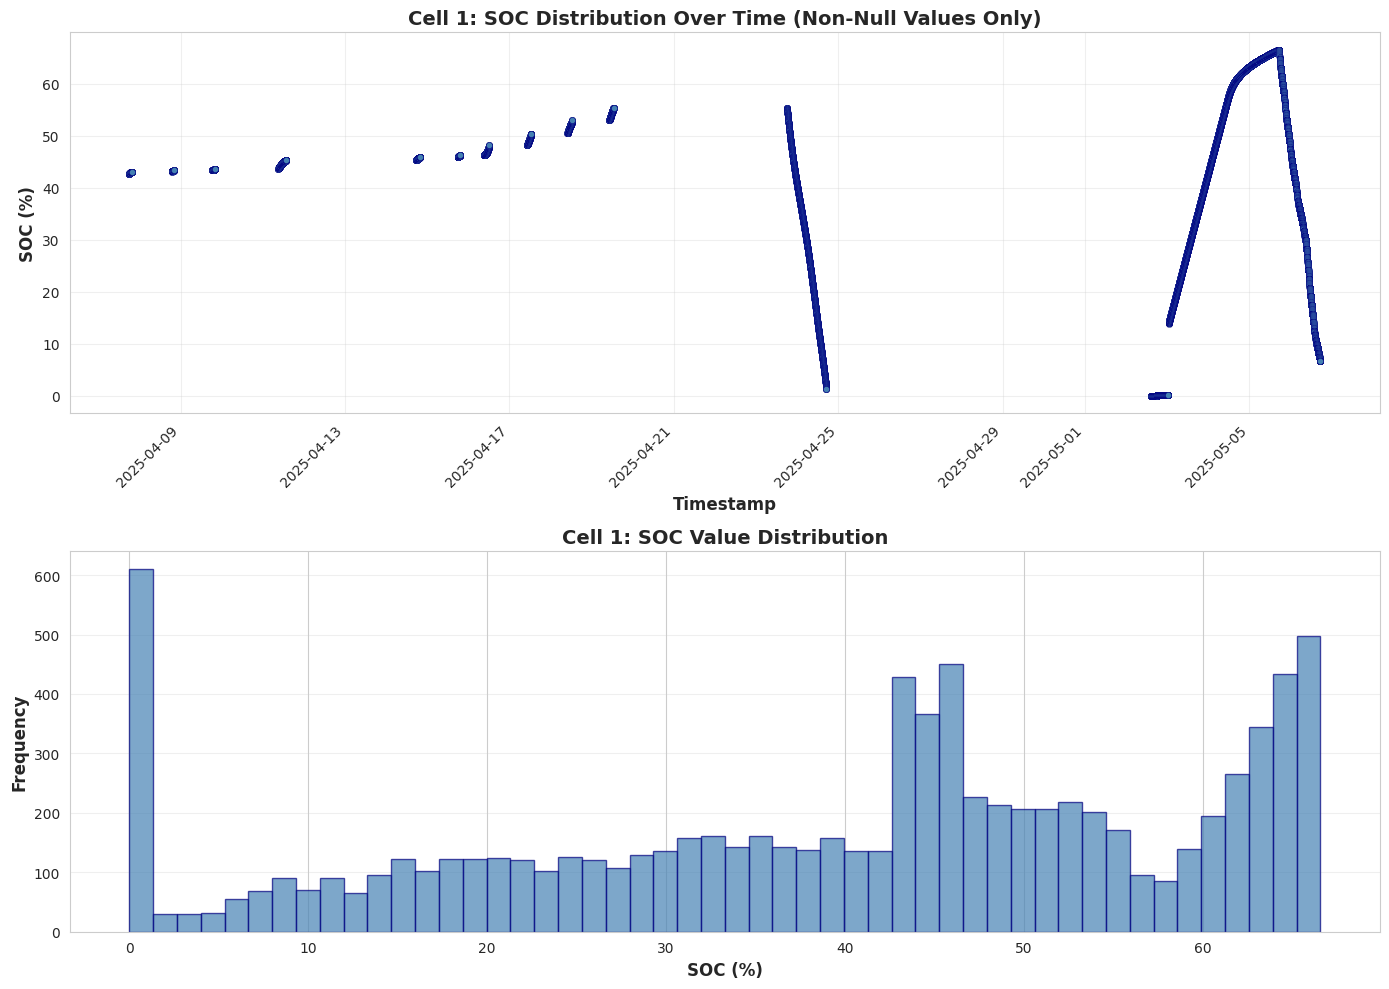


Time Gap Analysis (Cell 1):
Mean Time Gap: 286.23 seconds (4.77 minutes)
Median Time Gap: 60.00 seconds (1.00 minutes)
Min Time Gap: 0.00 seconds (0.00 minutes)
Max Time Gap: 682740.00 seconds (189.65 hours)
Std Dev Time Gap: 9139.09 seconds

Coefficient of Variation: 3192.93%

Distribution Assessment:
❌ Distribution: CLUSTERED IN SPECIFIC CHUNKS
   → Time gaps are highly irregular
   → SOC measurements are sporadic/clustered
   → Imputation may introduce significant errors
   → Consider dropping rows or using only non-null SOC data


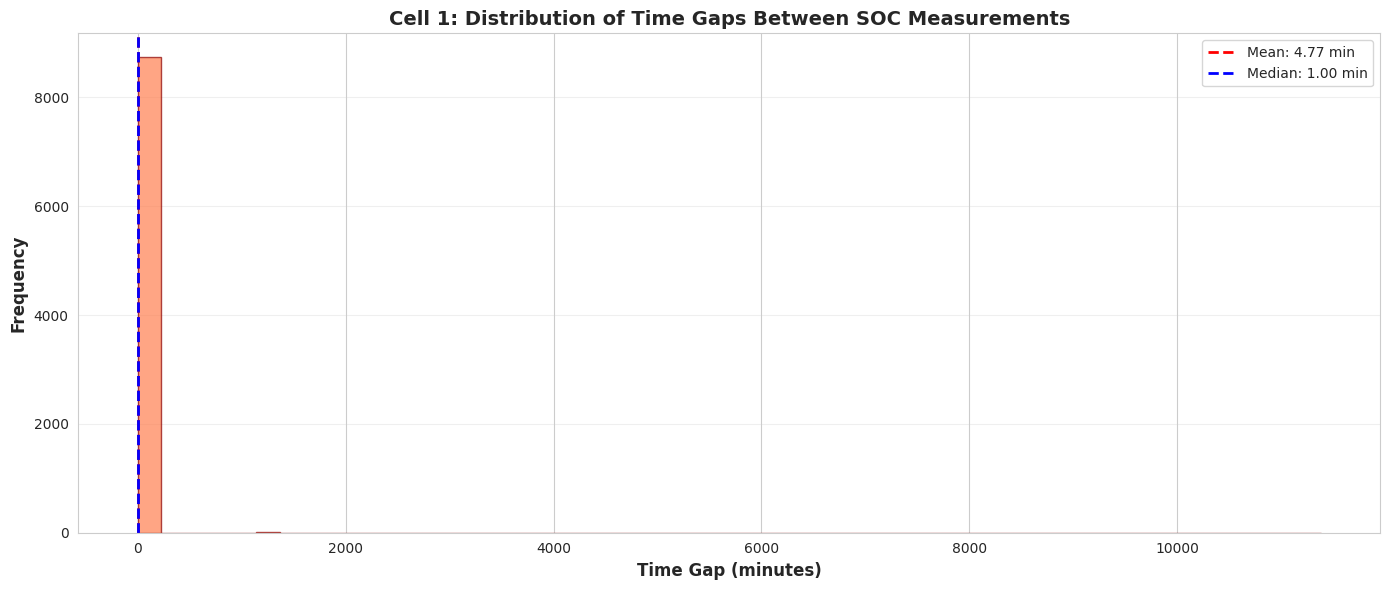


Correlation Analysis (Non-Null SOC Data):

Correlation Matrix:
               Voltage_V  Temperature_C  Current_A  SOC_Percent
Voltage_V       1.000000       0.614504   0.460374     0.060509
Temperature_C   0.614504       1.000000   0.130160    -0.110670
Current_A       0.460374       0.130160   1.000000    -0.056227
SOC_Percent     0.060509      -0.110670  -0.056227     1.000000

Key Correlations with SOC_Percent:
Voltage_V: 0.0605 (WEAK)
Current_A: -0.0562 (WEAK)
Temperature_C: -0.1107 (WEAK)


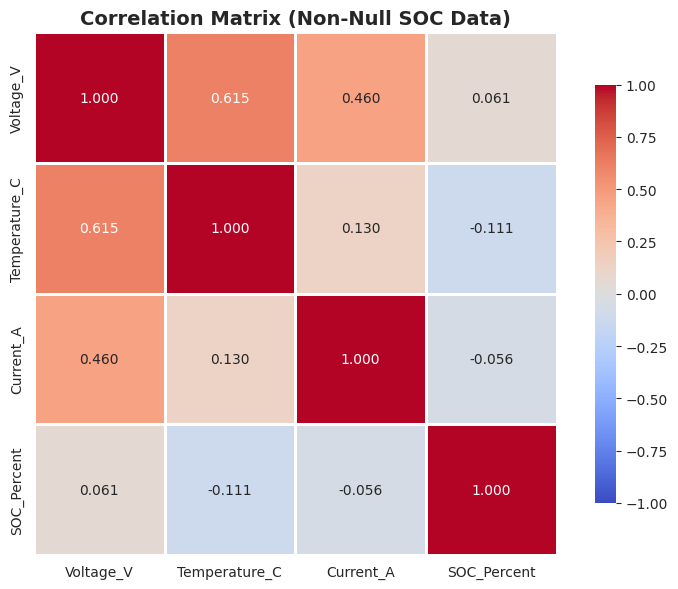


RECOMMENDATION:
⚠️  95.6% of data has missing SOC values
⚠️  RECOMMENDATION: Consider multiple strategies
   → Option 1: Train separate models for data with/without SOC
   → Option 2: Use SOC as optional feature with indicator variable
   → Option 3: Drop rows without SOC if other features suffice


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Load the processed data
print("Loading processed BMS data...")
df = pd.read_csv('processed_bms_data.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")

# Check SOC_Percent availability
print(f"\n{'='*70}")
print("SOC_Percent Column Analysis:")
print(f"{'='*70}")

if 'SOC_Percent' not in df.columns:
    print("⚠️ SOC_Percent column not found!")
    print(f"Available columns: {list(df.columns)}")
else:
    total_rows = len(df)
    null_rows = df['SOC_Percent'].isna().sum()
    non_null_rows = df['SOC_Percent'].notna().sum()
    null_percentage = (null_rows / total_rows) * 100
    
    print(f"Total rows: {total_rows:,}")
    print(f"Non-null SOC values: {non_null_rows:,} ({100-null_percentage:.2f}%)")
    print(f"Null SOC values: {null_rows:,} ({null_percentage:.2f}%)")
    
    # Filter for non-null SOC data
    df_with_soc = df[df['SOC_Percent'].notna()].copy()
    df_with_soc = df_with_soc.sort_values(['Cell_ID', 'Timestamp']).reset_index(drop=True)
    
    print(f"\n{'='*70}")
    print("Non-Null SOC Distribution by Cell:")
    print(f"{'='*70}")
    
    for cell_id in sorted(df_with_soc['Cell_ID'].unique()):
        cell_soc_count = len(df_with_soc[df_with_soc['Cell_ID'] == cell_id])
        cell_total = len(df[df['Cell_ID'] == cell_id])
        coverage = (cell_soc_count / cell_total) * 100 if cell_total > 0 else 0
        print(f"Cell {cell_id}: {cell_soc_count:,} / {cell_total:,} rows ({coverage:.2f}% coverage)")
    
    # Focus on Cell 1 for detailed analysis
    print(f"\n{'='*70}")
    print("Cell 1 Detailed Analysis:")
    print(f"{'='*70}")
    
    cell1_all = df[df['Cell_ID'] == 1].copy()
    cell1_with_soc = df_with_soc[df_with_soc['Cell_ID'] == 1].copy()
    cell1_with_soc = cell1_with_soc.sort_values('Timestamp').reset_index(drop=True)
    
    print(f"Cell 1 total rows: {len(cell1_all):,}")
    print(f"Cell 1 rows with SOC: {len(cell1_with_soc):,}")
    print(f"Coverage: {(len(cell1_with_soc)/len(cell1_all)*100):.2f}%")
    
    # Create scatter plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Timestamp vs SOC_Percent
    ax1.scatter(cell1_with_soc['Timestamp'], cell1_with_soc['SOC_Percent'], 
                alpha=0.6, s=20, c='steelblue', edgecolors='navy', linewidth=0.5)
    ax1.set_xlabel('Timestamp', fontsize=12, fontweight='bold')
    ax1.set_ylabel('SOC (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Cell 1: SOC Distribution Over Time (Non-Null Values Only)', 
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 2: Histogram of SOC values
    ax2.hist(cell1_with_soc['SOC_Percent'], bins=50, color='steelblue', 
             edgecolor='navy', alpha=0.7)
    ax2.set_xlabel('SOC (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Cell 1: SOC Value Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Gap Analysis
    print(f"\n{'='*70}")
    print("Time Gap Analysis (Cell 1):")
    print(f"{'='*70}")
    
    if len(cell1_with_soc) > 1:
        # Calculate time differences between consecutive measurements
        time_diffs = cell1_with_soc['Timestamp'].diff()
        time_diffs_seconds = time_diffs.dt.total_seconds()
        time_diffs_seconds = time_diffs_seconds.dropna()
        
        if len(time_diffs_seconds) > 0:
            mean_gap_seconds = time_diffs_seconds.mean()
            max_gap_seconds = time_diffs_seconds.max()
            min_gap_seconds = time_diffs_seconds.min()
            median_gap_seconds = time_diffs_seconds.median()
            std_gap_seconds = time_diffs_seconds.std()
            
            print(f"Mean Time Gap: {mean_gap_seconds:.2f} seconds ({mean_gap_seconds/60:.2f} minutes)")
            print(f"Median Time Gap: {median_gap_seconds:.2f} seconds ({median_gap_seconds/60:.2f} minutes)")
            print(f"Min Time Gap: {min_gap_seconds:.2f} seconds ({min_gap_seconds/60:.2f} minutes)")
            print(f"Max Time Gap: {max_gap_seconds:.2f} seconds ({max_gap_seconds/3600:.2f} hours)")
            print(f"Std Dev Time Gap: {std_gap_seconds:.2f} seconds")
            
            # Calculate coefficient of variation to assess uniformity
            cv = (std_gap_seconds / mean_gap_seconds) * 100
            print(f"\nCoefficient of Variation: {cv:.2f}%")
            
            # Distribution assessment
            print(f"\n{'='*70}")
            print("Distribution Assessment:")
            print(f"{'='*70}")
            
            if cv < 50:
                print("✅ Distribution: SPREAD OUT EVENLY")
                print("   → Time gaps are relatively uniform")
                print("   → SOC measurements occur at regular intervals")
                print("   → Good candidate for interpolation/imputation")
            elif cv < 100:
                print("⚠️  Distribution: MODERATELY VARIABLE")
                print("   → Time gaps show moderate variation")
                print("   → SOC measurements have some clustering")
                print("   → Consider conditional imputation based on test conditions")
            else:
                print("❌ Distribution: CLUSTERED IN SPECIFIC CHUNKS")
                print("   → Time gaps are highly irregular")
                print("   → SOC measurements are sporadic/clustered")
                print("   → Imputation may introduce significant errors")
                print("   → Consider dropping rows or using only non-null SOC data")
            
            # Create gap distribution plot
            fig, ax = plt.subplots(1, 1, figsize=(14, 6))
            ax.hist(time_diffs_seconds / 60, bins=50, color='coral', 
                   edgecolor='darkred', alpha=0.7)
            ax.set_xlabel('Time Gap (minutes)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
            ax.set_title('Cell 1: Distribution of Time Gaps Between SOC Measurements', 
                        fontsize=14, fontweight='bold')
            ax.axvline(mean_gap_seconds/60, color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {mean_gap_seconds/60:.2f} min')
            ax.axvline(median_gap_seconds/60, color='blue', linestyle='--', 
                      linewidth=2, label=f'Median: {median_gap_seconds/60:.2f} min')
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
    
    # Correlation Analysis
    print(f"\n{'='*70}")
    print("Correlation Analysis (Non-Null SOC Data):")
    print(f"{'='*70}")
    
    # Select numeric columns for correlation
    numeric_cols = ['Voltage_V', 'Temperature_C', 'Current_A', 'SOC_Percent']
    available_cols = [col for col in numeric_cols if col in df_with_soc.columns]
    
    if len(available_cols) >= 2:
        correlation_df = df_with_soc[available_cols].corr()
        
        print("\nCorrelation Matrix:")
        print(correlation_df.to_string())
        
        # Highlight key correlations with SOC
        if 'SOC_Percent' in correlation_df.columns:
            print(f"\n{'='*70}")
            print("Key Correlations with SOC_Percent:")
            print(f"{'='*70}")
            
            soc_correlations = correlation_df['SOC_Percent'].drop('SOC_Percent').sort_values(ascending=False)
            for feature, corr_value in soc_correlations.items():
                strength = "STRONG" if abs(corr_value) > 0.7 else "MODERATE" if abs(corr_value) > 0.4 else "WEAK"
                print(f"{feature}: {corr_value:.4f} ({strength})")
            
            # Heatmap
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0,
                       square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                       vmin=-1, vmax=1, fmt='.3f')
            ax.set_title('Correlation Matrix (Non-Null SOC Data)', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
    
    # Final Recommendation
    print(f"\n{'='*70}")
    print("RECOMMENDATION:")
    print(f"{'='*70}")
    
    if null_percentage > 50:
        print(f"⚠️  {null_percentage:.1f}% of data has missing SOC values")
        if cv < 50:
            print("✅ RECOMMENDATION: Impute missing SOC values")
            print("   → SOC measurements are evenly distributed")
            print("   → Use interpolation or ML-based imputation")
        else:
            print("⚠️  RECOMMENDATION: Consider multiple strategies")
            print("   → Option 1: Train separate models for data with/without SOC")
            print("   → Option 2: Use SOC as optional feature with indicator variable")
            print("   → Option 3: Drop rows without SOC if other features suffice")
    else:
        print(f"✅ Only {null_percentage:.1f}% missing SOC values")
        print("   → Consider dropping rows with missing SOC")
        print("   → Sufficient data remains for training")

Loading processed BMS data...
Total rows: 602,503
Cells: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Test conditions: 25

Calculating SOC using Coulomb Counting...

Processing Cell 1 - Eleventh Load - GC discharge...
  Rows: 8,196
  Cycle Type: discharge
  Capacity: 787.49 Ah
  SOC Range: 100.00% - 100.00%

Processing Cell 1 - Fifth Load-C10 discharge...
  Rows: 9,389
  Cycle Type: discharge
  Capacity: 2408.59 Ah
  SOC Range: 55.46% - 100.00%

Processing Cell 1 - First Charge-C20 discharge...
  Rows: 13,385
  Cycle Type: discharge
  Capacity: 4664.36 Ah
  SOC Range: 13.58% - 100.00%

Processing Cell 1 - Fourteenth Load - Discharge Pulses...
  Rows: 5,931
  Cycle Type: discharge
  Capacity: 719.67 Ah
  SOC Range: 100.00% - 100.00%

Processing Cell 1 - Fourth Load-C20 discharge...
  Rows: 9,878
  Cycle Type: discharge
  Capacity: 1204.41 Ah
  SOC Range: 100.00% - 100.00%

Processing Cell 1 - Ninth and Tenth Photovoltaic Load Cloudy - C10 dis...
  Rows:

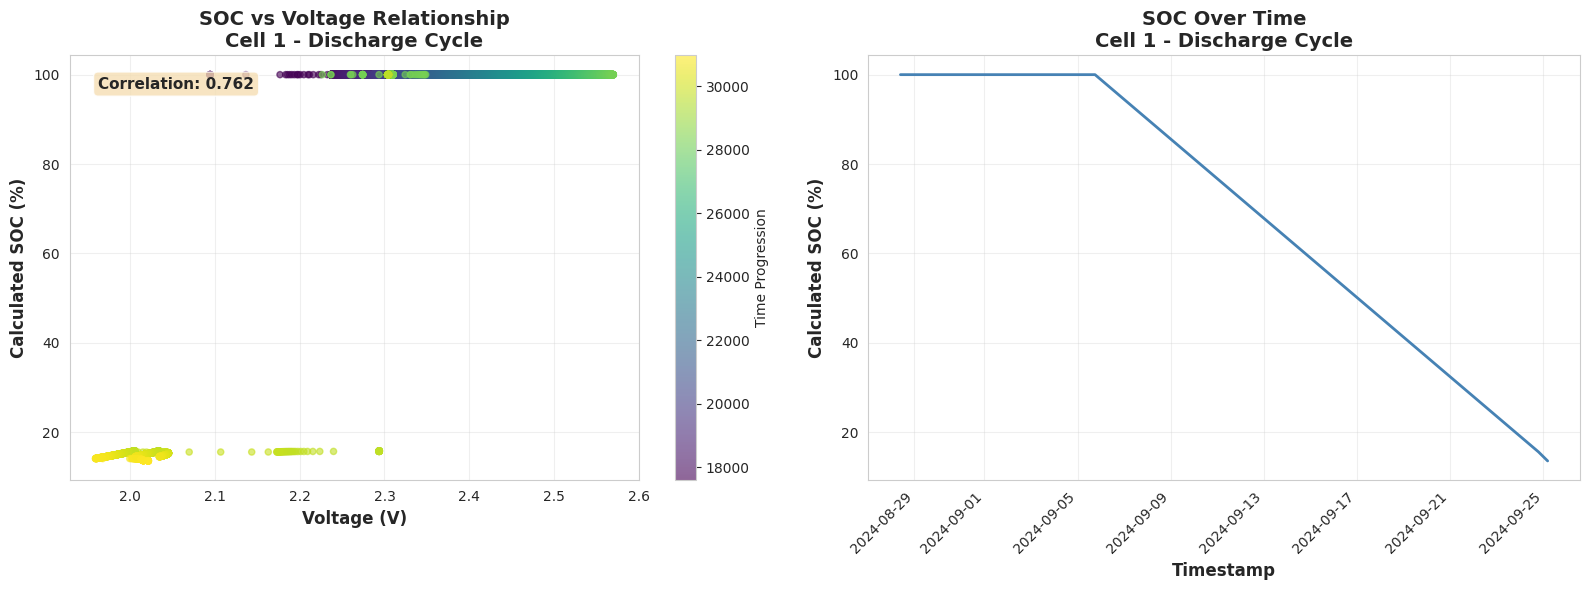


✅ Expected behavior for discharge cycle:
   - SOC should decrease from ~100% to near 0%
   - Voltage should decrease as SOC decreases
   - Correlation should be POSITIVE and STRONG (>0.7)

   Actual correlation: 0.762
   ✅ EXCELLENT - Strong positive correlation!

✅ SOC Calculation Complete!

Next steps:
  1. Review the SOC vs Voltage plot - should show clear relationship
  2. Check that discharge cycles go from 100% → 0%
  3. Check that charge cycles go from 0% → 100%
  4. Use 'Calculated_SOC' as your target variable for ML training

Dataset saved: bms_training_data_engineered.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Load the processed data
print("Loading processed BMS data...")
df = pd.read_csv('processed_bms_data.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

print(f"Total rows: {len(df):,}")
print(f"Cells: {sorted(df['Cell_ID'].unique())}")
print(f"Test conditions: {len(df['Test_Condition'].unique())}")

# Function to determine if a test is a charge or discharge cycle
def determine_cycle_type(test_name):
    """Determine if test is primarily charge or discharge based on name"""
    test_lower = test_name.lower()
    
    # Check for discharge indicators
    if 'discharge' in test_lower or 'dis' in test_lower:
        return 'discharge'
    # Check for charge indicators  
    elif 'charge' in test_lower or 'photovoltaic' in test_lower or 'load clear' in test_lower:
        return 'charge'
    else:
        # Default: check the average current in the actual data
        return 'unknown'

# Function to calculate SOC using Coulomb Counting
def calculate_soc_coulomb_counting(group_df, default_capacity_ah=200):
    """
    Calculate SOC using Coulomb Counting method
    
    Parameters:
    -----------
    group_df : DataFrame
        Data for a single cell and test condition
    default_capacity_ah : float
        Default battery capacity in Ah
        
    Returns:
    --------
    DataFrame with Calculated_SOC column
    """
    # Make a copy and sort by timestamp
    df_calc = group_df.copy()
    df_calc = df_calc.sort_values('Timestamp').reset_index(drop=True)
    
    # Check if we have required columns
    if 'Current_A' not in df_calc.columns or 'Timestamp' not in df_calc.columns:
        print(f"  ⚠️  Missing required columns, skipping...")
        df_calc['Calculated_SOC'] = np.nan
        return df_calc
    
    # Calculate time differences in hours
    df_calc['Time_Diff_Hours'] = df_calc['Timestamp'].diff().dt.total_seconds() / 3600
    
    # Handle first row (no time difference)
    df_calc.loc[0, 'Time_Diff_Hours'] = 0
    
    # Calculate Ah change for each timestep: Current (A) * Time (h)
    df_calc['Delta_Ah'] = df_calc['Current_A'] * df_calc['Time_Diff_Hours']
    
    # Determine cycle type
    test_name = df_calc['Test_Condition'].iloc[0] if 'Test_Condition' in df_calc.columns else 'unknown'
    cycle_type = determine_cycle_type(test_name)
    
    # If unknown, determine from actual current
    if cycle_type == 'unknown':
        avg_current = df_calc['Current_A'].mean()
        cycle_type = 'discharge' if avg_current < 0 else 'charge'
    
    # Calculate total capacity from discharge data
    discharge_data = df_calc[df_calc['Current_A'] < 0]
    total_discharged_ah = abs(discharge_data['Delta_Ah'].sum())
    
    # Determine capacity to use
    if total_discharged_ah > 1:  # Significant discharge occurred
        capacity_ah = total_discharged_ah
    else:
        capacity_ah = default_capacity_ah
    
    # Set starting SOC based on cycle type
    if cycle_type == 'discharge':
        start_soc = 100.0  # Start fully charged
    else:
        start_soc = 0.0    # Start empty for charging
    
    # Calculate cumulative Ah
    df_calc['Cumulative_Ah'] = df_calc['Delta_Ah'].cumsum()
    
    # Calculate SOC
    # For discharge: SOC decreases (negative current decreases SOC)
    # For charge: SOC increases (positive current increases SOC)
    df_calc['Calculated_SOC'] = start_soc + (df_calc['Cumulative_Ah'] / capacity_ah * 100)
    
    # Clip SOC between 0 and 100
    df_calc['Calculated_SOC'] = df_calc['Calculated_SOC'].clip(0, 100)
    
    # Clean up temporary columns
    df_calc = df_calc.drop(columns=['Time_Diff_Hours', 'Delta_Ah', 'Cumulative_Ah'])
    
    return df_calc, cycle_type, capacity_ah

# Process each Cell + Test Condition group
print(f"\n{'='*70}")
print("Calculating SOC using Coulomb Counting...")
print(f"{'='*70}\n")

processed_groups = []
summary_stats = []

# Group by Cell_ID and Test_Condition
grouped = df.groupby(['Cell_ID', 'Test_Condition'])

for (cell_id, test_condition), group in grouped:
    print(f"Processing Cell {cell_id} - {test_condition[:50]}...")
    print(f"  Rows: {len(group):,}")
    
    # Calculate SOC
    processed_group, cycle_type, capacity = calculate_soc_coulomb_counting(group)
    processed_groups.append(processed_group)
    
    # Store summary
    summary_stats.append({
        'Cell_ID': cell_id,
        'Test_Condition': test_condition,
        'Rows': len(group),
        'Cycle_Type': cycle_type,
        'Capacity_Ah': capacity,
        'SOC_Min': processed_group['Calculated_SOC'].min(),
        'SOC_Max': processed_group['Calculated_SOC'].max(),
        'SOC_Mean': processed_group['Calculated_SOC'].mean()
    })
    
    print(f"  Cycle Type: {cycle_type}")
    print(f"  Capacity: {capacity:.2f} Ah")
    print(f"  SOC Range: {processed_group['Calculated_SOC'].min():.2f}% - {processed_group['Calculated_SOC'].max():.2f}%")
    print()

# Combine all processed groups
print(f"{'='*70}")
print("Merging all groups...")
df_engineered = pd.concat(processed_groups, ignore_index=True)

# Sort by Cell, Test, and Timestamp
df_engineered = df_engineered.sort_values(['Cell_ID', 'Test_Condition', 'Timestamp']).reset_index(drop=True)

print(f"Total rows in engineered dataset: {len(df_engineered):,}")
print(f"Calculated_SOC - Missing values: {df_engineered['Calculated_SOC'].isna().sum()}")
print(f"Calculated_SOC - Range: {df_engineered['Calculated_SOC'].min():.2f}% - {df_engineered['Calculated_SOC'].max():.2f}%")

# Save the engineered dataset
output_file = 'bms_training_data_engineered.csv'
df_engineered.to_csv(output_file, index=False)
print(f"\n✅ Saved engineered dataset to: {output_file}")

# Display summary statistics
print(f"\n{'='*70}")
print("Summary Statistics by Test:")
print(f"{'='*70}\n")

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

# Verification Plot: SOC vs Voltage for a discharge cycle
print(f"\n{'='*70}")
print("Creating Verification Plot...")
print(f"{'='*70}\n")

# Find a good discharge cycle to plot
discharge_tests = summary_df[summary_df['Cycle_Type'] == 'discharge'].sort_values('Rows', ascending=False)

if len(discharge_tests) > 0:
    # Use the discharge test with most data points
    best_test = discharge_tests.iloc[0]
    cell_id = best_test['Cell_ID']
    test_condition = best_test['Test_Condition']
    
    print(f"Plotting: Cell {cell_id} - {test_condition}")
    
    # Filter data
    plot_data = df_engineered[
        (df_engineered['Cell_ID'] == cell_id) & 
        (df_engineered['Test_Condition'] == test_condition)
    ].copy()
    
    if 'Voltage_V' in plot_data.columns and len(plot_data) > 0:
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: SOC vs Voltage
        scatter = ax1.scatter(plot_data['Voltage_V'], plot_data['Calculated_SOC'], 
                             c=plot_data.index, cmap='viridis', alpha=0.6, s=20)
        ax1.set_xlabel('Voltage (V)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Calculated SOC (%)', fontsize=12, fontweight='bold')
        ax1.set_title(f'SOC vs Voltage Relationship\nCell {cell_id} - Discharge Cycle', 
                     fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax1, label='Time Progression')
        
        # Calculate and display correlation
        if plot_data['Voltage_V'].notna().sum() > 0 and plot_data['Calculated_SOC'].notna().sum() > 0:
            correlation = plot_data[['Voltage_V', 'Calculated_SOC']].corr().iloc[0, 1]
            ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                    transform=ax1.transAxes, fontsize=11, fontweight='bold',
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Plot 2: SOC over Time
        ax2.plot(plot_data['Timestamp'], plot_data['Calculated_SOC'], 
                color='steelblue', linewidth=2)
        ax2.set_xlabel('Timestamp', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Calculated SOC (%)', fontsize=12, fontweight='bold')
        ax2.set_title(f'SOC Over Time\nCell {cell_id} - Discharge Cycle', 
                     fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ Expected behavior for discharge cycle:")
        print(f"   - SOC should decrease from ~100% to near 0%")
        print(f"   - Voltage should decrease as SOC decreases")
        print(f"   - Correlation should be POSITIVE and STRONG (>0.7)")
        print(f"\n   Actual correlation: {correlation:.3f}")
        
        if correlation > 0.7:
            print(f"   ✅ EXCELLENT - Strong positive correlation!")
        elif correlation > 0.5:
            print(f"   ✓ GOOD - Moderate positive correlation")
        else:
            print(f"   ⚠️  WEAK - May need refinement")
    else:
        print("⚠️  Missing Voltage_V column for plotting")
else:
    print("⚠️  No discharge cycles found for verification plot")

print(f"\n{'='*70}")
print("✅ SOC Calculation Complete!")
print(f"{'='*70}")
print("\nNext steps:")
print("  1. Review the SOC vs Voltage plot - should show clear relationship")
print("  2. Check that discharge cycles go from 100% → 0%")
print("  3. Check that charge cycles go from 0% → 100%")
print("  4. Use 'Calculated_SOC' as your target variable for ML training")
print(f"\nDataset saved: {output_file}")

Loading BMS training data...
Initial dataset shape: (602503, 10)
Columns: ['Timestamp', 'Voltage_mV', 'Voltage_V', 'Temperature_C', 'Current_A', 'Capacity_Ah', 'Cell_ID', 'Test_Condition', 'SOC_Percent', 'Calculated_SOC']

FEATURE ENGINEERING PIPELINE

✓ All required columns present

1️⃣  Calculating Physics Features...
----------------------------------------------------------------------
✓ Power_W created
  Range: -1226.86 to 35.17 W
  Mean: -1.86 W
  Missing values: 23055

2️⃣  Calculating Time-Derivative Features...
----------------------------------------------------------------------


/tmp/ipykernel_55/1393256501.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(calculate_derivatives)


✓ Voltage_Change created
  Range: -18.4028 to 18.4027
  Mean: -0.0000
✓ Temp_Change created
  Range: -1.6900 to 1.6900
  Mean: 0.0001
✓ SOC_Change created
  Range: -84.1784 to 56.0604
  Mean: -0.0068
✓ Current_Change created
  Range: -121.8600 to 121.8400
  Mean: -0.0058

3️⃣  Calculating Moving Average Features...
----------------------------------------------------------------------


/tmp/ipykernel_55/1393256501.py:134: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(


✓ Voltage_MovAvg_10m created
  Range: 1.8986 to 5.7256
  Mean: 2.2145
  Missing values: 23000
✓ Current_MovAvg_10m created
  Range: -120.0070 to 15.0080
  Mean: -1.4972
  Missing values: 23000
✓ Temp_MovAvg_10m created
  Range: 20.1100 to 29.3620
  Mean: 24.5724
  Missing values: 23000
✓ SOC_MovAvg_10m created
  Range: 0.2999 to 100.0000
  Mean: 92.2383
  Missing values: 23000
✓ Power_MovAvg_10m created
  Range: -343.5361 to 35.1294
  Mean: -1.7993
  Missing values: 23000

4️⃣  Calculating Additional Derived Features...
----------------------------------------------------------------------
✓ Voltage_Deviation created
✓ Current_Deviation created


/tmp/ipykernel_55/1393256501.py:177: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(


✓ Cumulative_Energy_Wh created

SAVING ENHANCED DATASET

✓ Saved to: bms_training_data_enhanced.csv
  Original columns: 10
  Enhanced columns: 23
  New features added: 13
  Total rows: 602,503
  File size: True

New features created:
  1. Power_W
  2. Voltage_Change
  3. Temp_Change
  4. SOC_Change
  5. Current_Change
  6. Voltage_MovAvg_10m
  7. Current_MovAvg_10m
  8. Temp_MovAvg_10m
  9. SOC_MovAvg_10m
  10. Power_MovAvg_10m
  11. Voltage_Deviation
  12. Current_Deviation
  13. Cumulative_Energy_Wh

CORRELATION ANALYSIS WITH CALCULATED_SOC

Top 15 Features Correlated with Calculated_SOC:
----------------------------------------------------------------------
 1. 🔥 SOC_MovAvg_10m                  0.9994 (STRONG) [NEW]
 2. 🔥 Cumulative_Energy_Wh            0.7394 (STRONG) [NEW]
 3. ○ Voltage_MovAvg_10m              0.3956 (WEAK) [NEW]
 4. ○ Voltage_mV                      0.3791 (WEAK)
 5. ○ Voltage_V                       0.3791 (WEAK)
 6. ○ Power_MovAvg_10m                0.3110 (WEA

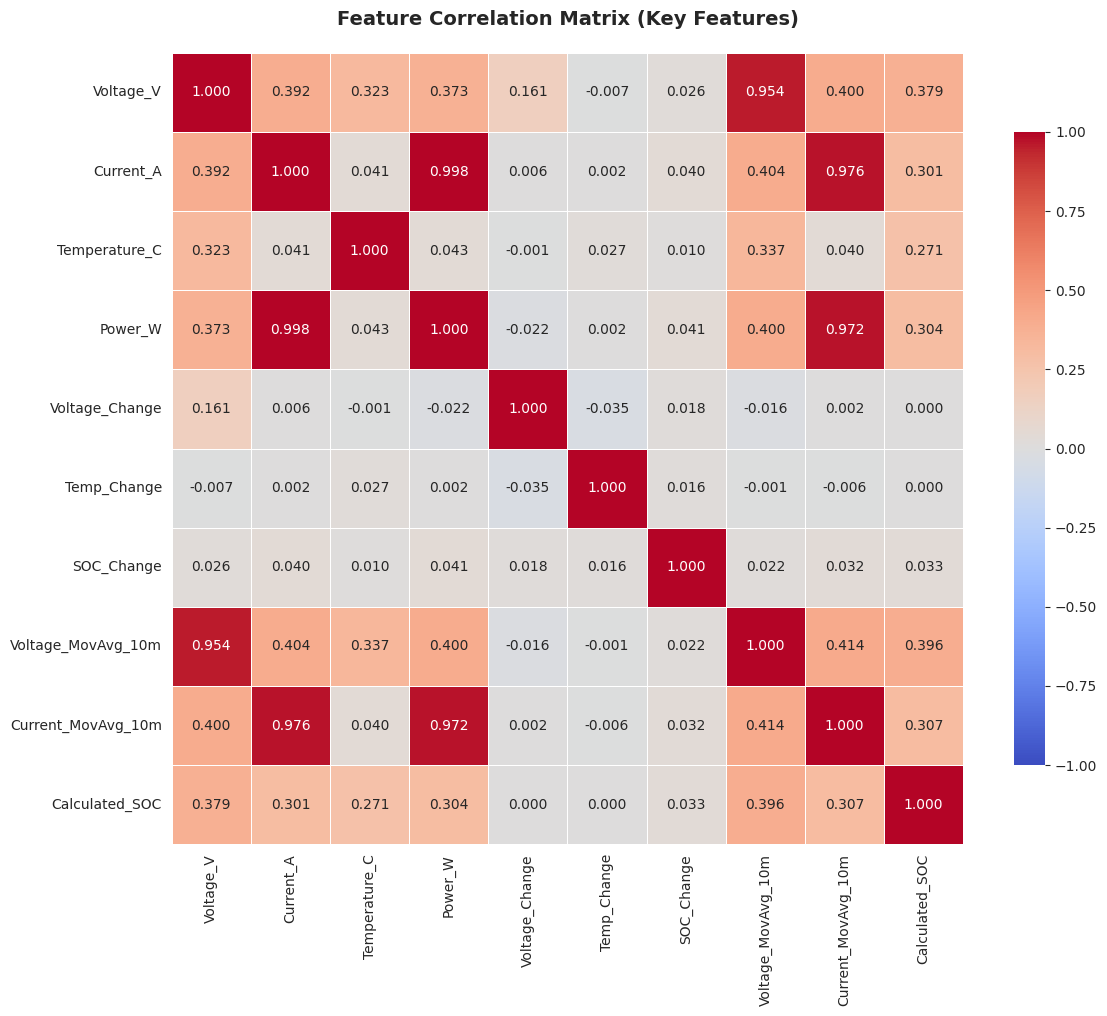

✓ Heatmap displayed

✅ FEATURE ENGINEERING COMPLETE!

Summary:
  • Dataset enhanced with 13 new features
  • Physics features: Power, Energy
  • Derivative features: Voltage/Temp/SOC/Current changes
  • Trend features: Moving averages (10-point window)
  • Deviation features: Short-term fluctuations

Next steps for ML:
  1. Use these features for LSTM/Random Forest training
  2. Features like 'Power_W' and 'Voltage_Change' give physics context
  3. Moving averages help capture temporal trends
  4. Consider feature importance analysis after training

Enhanced dataset: bms_training_data_enhanced.csv


In [7]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# Load the engineered dataset
print("Loading BMS training data...")
df = pd.read_csv('bms_training_data_engineered.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

print(f"Initial dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print(f"\n{'='*70}")
print("FEATURE ENGINEERING PIPELINE")
print(f"{'='*70}\n")

# Check for required columns
required_cols = ['Voltage_V', 'Current_A', 'Temperature_C', 'Calculated_SOC']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"⚠️  Warning: Missing columns: {missing_cols}")
    print("Available columns:", list(df.columns))
else:
    print("✓ All required columns present\n")

# Create a copy for feature engineering
df_enhanced = df.copy()

# ========================================================================
# 1. PHYSICS CALCULATIONS
# ========================================================================
print("1️⃣  Calculating Physics Features...")
print("-" * 70)

if 'Voltage_V' in df_enhanced.columns and 'Current_A' in df_enhanced.columns:
    # Power = Voltage × Current
    df_enhanced['Power_W'] = df_enhanced['Voltage_V'] * df_enhanced['Current_A']
    
    print(f"✓ Power_W created")
    print(f"  Range: {df_enhanced['Power_W'].min():.2f} to {df_enhanced['Power_W'].max():.2f} W")
    print(f"  Mean: {df_enhanced['Power_W'].mean():.2f} W")
    print(f"  Missing values: {df_enhanced['Power_W'].isna().sum()}")
else:
    print("⚠️  Cannot calculate Power - missing Voltage or Current")

print()

# ========================================================================
# 2. TIME-DERIVATIVE FEATURES (Rate of Change)
# ========================================================================
print("2️⃣  Calculating Time-Derivative Features...")
print("-" * 70)

# Sort by Cell_ID, Test_Condition, and Timestamp to ensure proper ordering
df_enhanced = df_enhanced.sort_values(['Cell_ID', 'Test_Condition', 'Timestamp']).reset_index(drop=True)

# Calculate derivatives within each Cell + Test group to avoid boundary issues
def calculate_derivatives(group):
    """Calculate derivatives within each group"""
    group = group.copy()
    
    # Voltage change
    if 'Voltage_V' in group.columns:
        group['Voltage_Change'] = group['Voltage_V'].diff()
    
    # Temperature change
    if 'Temperature_C' in group.columns:
        group['Temp_Change'] = group['Temperature_C'].diff()
    
    # SOC change (rate of SOC change)
    if 'Calculated_SOC' in group.columns:
        group['SOC_Change'] = group['Calculated_SOC'].diff()
    
    # Current change (acceleration in current)
    if 'Current_A' in group.columns:
        group['Current_Change'] = group['Current_A'].diff()
    
    return group

# Apply derivative calculation to each group
df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(calculate_derivatives)

# Fill NaN values in first rows with 0
derivative_cols = ['Voltage_Change', 'Temp_Change', 'SOC_Change', 'Current_Change']
for col in derivative_cols:
    if col in df_enhanced.columns:
        df_enhanced[col] = df_enhanced[col].fillna(0)
        print(f"✓ {col} created")
        print(f"  Range: {df_enhanced[col].min():.4f} to {df_enhanced[col].max():.4f}")
        print(f"  Mean: {df_enhanced[col].mean():.4f}")

print()

# ========================================================================
# 3. MOVING AVERAGES (Trends)
# ========================================================================
print("3️⃣  Calculating Moving Average Features...")
print("-" * 70)

# Calculate moving averages within each Cell + Test group
def calculate_moving_averages(group, window=10):
    """Calculate moving averages within each group"""
    group = group.copy()
    
    # Voltage moving average
    if 'Voltage_V' in group.columns:
        group['Voltage_MovAvg_10m'] = group['Voltage_V'].rolling(
            window=window, min_periods=1).mean()
    
    # Current moving average
    if 'Current_A' in group.columns:
        group['Current_MovAvg_10m'] = group['Current_A'].rolling(
            window=window, min_periods=1).mean()
    
    # Temperature moving average
    if 'Temperature_C' in group.columns:
        group['Temp_MovAvg_10m'] = group['Temperature_C'].rolling(
            window=window, min_periods=1).mean()
    
    # SOC moving average (smoothed SOC)
    if 'Calculated_SOC' in group.columns:
        group['SOC_MovAvg_10m'] = group['Calculated_SOC'].rolling(
            window=window, min_periods=1).mean()
    
    # Power moving average
    if 'Power_W' in group.columns:
        group['Power_MovAvg_10m'] = group['Power_W'].rolling(
            window=window, min_periods=1).mean()
    
    return group

# Apply moving average calculation to each group
df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(
    calculate_moving_averages)

moving_avg_cols = ['Voltage_MovAvg_10m', 'Current_MovAvg_10m', 'Temp_MovAvg_10m', 
                   'SOC_MovAvg_10m', 'Power_MovAvg_10m']
for col in moving_avg_cols:
    if col in df_enhanced.columns:
        print(f"✓ {col} created")
        print(f"  Range: {df_enhanced[col].min():.4f} to {df_enhanced[col].max():.4f}")
        print(f"  Mean: {df_enhanced[col].mean():.4f}")
        print(f"  Missing values: {df_enhanced[col].isna().sum()}")

print()

# ========================================================================
# 4. ADDITIONAL DERIVED FEATURES
# ========================================================================
print("4️⃣  Calculating Additional Derived Features...")
print("-" * 70)

# Voltage deviation from moving average (captures short-term fluctuations)
if 'Voltage_V' in df_enhanced.columns and 'Voltage_MovAvg_10m' in df_enhanced.columns:
    df_enhanced['Voltage_Deviation'] = df_enhanced['Voltage_V'] - df_enhanced['Voltage_MovAvg_10m']
    print(f"✓ Voltage_Deviation created")

# Current deviation from moving average
if 'Current_A' in df_enhanced.columns and 'Current_MovAvg_10m' in df_enhanced.columns:
    df_enhanced['Current_Deviation'] = df_enhanced['Current_A'] - df_enhanced['Current_MovAvg_10m']
    print(f"✓ Current_Deviation created")

# Energy throughput (cumulative energy)
if 'Power_W' in df_enhanced.columns:
    def calculate_cumulative_energy(group):
        group = group.copy()
        # Calculate time difference in hours
        group['Time_Diff_Hours'] = group['Timestamp'].diff().dt.total_seconds() / 3600
        group['Time_Diff_Hours'] = group['Time_Diff_Hours'].fillna(0)
        # Energy = Power * Time
        group['Energy_Wh'] = group['Power_W'] * group['Time_Diff_Hours']
        group['Cumulative_Energy_Wh'] = group['Energy_Wh'].cumsum()
        group = group.drop(columns=['Time_Diff_Hours', 'Energy_Wh'])
        return group
    
    df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(
        calculate_cumulative_energy)
    print(f"✓ Cumulative_Energy_Wh created")

print()

# ========================================================================
# 5. SAVE ENHANCED DATASET
# ========================================================================
print(f"{'='*70}")
print("SAVING ENHANCED DATASET")
print(f"{'='*70}\n")

output_file = 'bms_training_data_enhanced.csv'
df_enhanced.to_csv(output_file, index=False)

print(f"✓ Saved to: {output_file}")
print(f"  Original columns: {len(df.columns)}")
print(f"  Enhanced columns: {len(df_enhanced.columns)}")
print(f"  New features added: {len(df_enhanced.columns) - len(df.columns)}")
print(f"  Total rows: {len(df_enhanced):,}")
print(f"  File size: {pd.io.common.file_exists(output_file)}")

# List all new features
new_features = [col for col in df_enhanced.columns if col not in df.columns]
print(f"\nNew features created:")
for i, feature in enumerate(new_features, 1):
    print(f"  {i}. {feature}")

print()

# ========================================================================
# 6. CORRELATION ANALYSIS
# ========================================================================
print(f"{'='*70}")
print("CORRELATION ANALYSIS WITH CALCULATED_SOC")
print(f"{'='*70}\n")

if 'Calculated_SOC' in df_enhanced.columns:
    # Select numeric columns
    numeric_cols = df_enhanced.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove identifier columns
    exclude_cols = ['Cell_ID']
    feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Calculate correlation with Calculated_SOC
    correlations = df_enhanced[feature_cols].corr()['Calculated_SOC'].drop('Calculated_SOC')
    correlations = correlations.sort_values(ascending=False)
    
    print("Top 15 Features Correlated with Calculated_SOC:")
    print("-" * 70)
    
    for i, (feature, corr_value) in enumerate(correlations.head(15).items(), 1):
        # Determine strength
        abs_corr = abs(corr_value)
        if abs_corr > 0.7:
            strength = "STRONG"
            symbol = "🔥"
        elif abs_corr > 0.5:
            strength = "MODERATE"
            symbol = "✓"
        else:
            strength = "WEAK"
            symbol = "○"
        
        # Highlight new features
        is_new = feature in new_features
        marker = " [NEW]" if is_new else ""
        
        print(f"{i:2d}. {symbol} {feature:30s} {corr_value:7.4f} ({strength}){marker}")
    
    print("\n" + "-" * 70)
    print("Bottom 5 Features (Negative Correlation):")
    print("-" * 70)
    
    for i, (feature, corr_value) in enumerate(correlations.tail(5).items(), 1):
        is_new = feature in new_features
        marker = " [NEW]" if is_new else ""
        print(f"{i:2d}. {feature:30s} {corr_value:7.4f}{marker}")
    
    # Focus on NEW features only
    new_feature_correlations = correlations[correlations.index.isin(new_features)]
    
    if len(new_feature_correlations) > 0:
        print(f"\n{'='*70}")
        print("NEW FEATURES CORRELATION WITH CALCULATED_SOC")
        print(f"{'='*70}\n")
        
        print("Physics Features:")
        print("-" * 70)
        physics_features = [f for f in new_feature_correlations.index if 'Power' in f or 'Energy' in f]
        for feature in physics_features:
            corr = new_feature_correlations[feature]
            print(f"  {feature:35s} {corr:7.4f}")
        
        print("\nTime-Derivative Features:")
        print("-" * 70)
        derivative_features = [f for f in new_feature_correlations.index if 'Change' in f or 'Deviation' in f]
        for feature in derivative_features:
            corr = new_feature_correlations[feature]
            print(f"  {feature:35s} {corr:7.4f}")
        
        print("\nMoving Average Features:")
        print("-" * 70)
        movavg_features = [f for f in new_feature_correlations.index if 'MovAvg' in f]
        for feature in movavg_features:
            corr = new_feature_correlations[feature]
            print(f"  {feature:35s} {corr:7.4f}")
    
    # Create correlation heatmap for key features
    print(f"\n{'='*70}")
    print("Creating Correlation Heatmap...")
    print(f"{'='*70}\n")
    
    # Select key features for visualization
    key_features = ['Voltage_V', 'Current_A', 'Temperature_C', 'Power_W', 
                   'Voltage_Change', 'Temp_Change', 'SOC_Change',
                   'Voltage_MovAvg_10m', 'Current_MovAvg_10m', 'Calculated_SOC']
    
    available_key_features = [f for f in key_features if f in df_enhanced.columns]
    
    if len(available_key_features) > 2:
        corr_matrix = df_enhanced[available_key_features].corr()
        
        # Create heatmap
        fig, ax = plt.subplots(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                   vmin=-1, vmax=1, fmt='.3f', ax=ax)
        ax.set_title('Feature Correlation Matrix (Key Features)', 
                    fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        print("✓ Heatmap displayed")
    
else:
    print("⚠️  Calculated_SOC column not found!")

# ========================================================================
# SUMMARY
# ========================================================================
print(f"\n{'='*70}")
print("✅ FEATURE ENGINEERING COMPLETE!")
print(f"{'='*70}\n")

print("Summary:")
print(f"  • Dataset enhanced with {len(new_features)} new features")
print(f"  • Physics features: Power, Energy")
print(f"  • Derivative features: Voltage/Temp/SOC/Current changes")
print(f"  • Trend features: Moving averages (10-point window)")
print(f"  • Deviation features: Short-term fluctuations")
print(f"\nNext steps for ML:")
print(f"  1. Use these features for LSTM/Random Forest training")
print(f"  2. Features like 'Power_W' and 'Voltage_Change' give physics context")
print(f"  3. Moving averages help capture temporal trends")
print(f"  4. Consider feature importance analysis after training")
print(f"\nEnhanced dataset: {output_file}")

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import os

# ========================================================================
# GLOBAL CONFIGURATION - Change this for different deployment scenarios
# ========================================================================
SEQ_LENGTH = 10  # Lookback window (timesteps)
# For IoT sensors: 5-10 steps (lightweight, low memory)
# For cloud/edge: 30-60 steps (heavy, better accuracy)
# ========================================================================

print(f"{'='*70}")
print("LSTM DATA PREPROCESSING & WINDOWING PIPELINE")
print(f"{'='*70}")
print(f"Configuration: SEQ_LENGTH = {SEQ_LENGTH} timesteps")
print(f"{'='*70}\n")

# ========================================================================
# 1. LOAD DATA
# ========================================================================
print("1️⃣  Loading enhanced BMS data...")
print("-" * 70)

df = pd.read_csv('bms_training_data_enhanced.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

print(f"✓ Data loaded successfully")
print(f"  Total rows: {len(df):,}")
print(f"  Total columns: {len(df.columns)}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print()

# ========================================================================
# 2. FEATURE SELECTION
# ========================================================================
print("2️⃣  Selecting features...")
print("-" * 70)

# Define input features (X)
input_features = [
    'Voltage_V',
    'Current_A', 
    'Temperature_C',
    'Power_W',
    'Voltage_MovAvg_10m',
    'Current_MovAvg_10m',
    'Voltage_Change'
]

# Define target (Y)
target_feature = 'Calculated_SOC'

# Verify all features exist
missing_features = [f for f in input_features + [target_feature] if f not in df.columns]

if missing_features:
    print(f"❌ Missing features: {missing_features}")
    print(f"Available columns: {list(df.columns)}")
    raise ValueError("Required features not found in dataset")

print(f"✓ Input features ({len(input_features)}):")
for i, feature in enumerate(input_features, 1):
    print(f"  {i}. {feature}")

print(f"\n✓ Target feature: {target_feature}")

# Check for missing values
print(f"\nChecking for missing values...")
missing_count = 0
for feature in input_features + [target_feature]:
    missing = df[feature].isna().sum()
    if missing > 0:
        print(f"  ⚠️  {feature}: {missing:,} missing values ({missing/len(df)*100:.2f}%)")
        missing_count += missing

# Drop rows with any missing values in selected features
df_clean = df.dropna(subset=input_features + [target_feature])
print(f"\n✓ Rows after dropping NaN: {len(df_clean):,} (removed {len(df) - len(df_clean):,})")

print()

# ========================================================================
# 3. SCALING
# ========================================================================
print("3️⃣  Scaling features...")
print("-" * 70)

# Create scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Extract features
X = df_clean[input_features].values
y = df_clean[[target_feature]].values  # Keep 2D shape for scaler

print(f"Original X shape: {X.shape}")
print(f"Original y shape: {y.shape}")

# Fit and transform
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print(f"\n✓ Features scaled to range (0, 1)")
print(f"  X_scaled shape: {X_scaled.shape}")
print(f"  y_scaled shape: {y_scaled.shape}")
print(f"  X range: [{X_scaled.min():.4f}, {X_scaled.max():.4f}]")
print(f"  y range: [{y_scaled.min():.4f}, {y_scaled.max():.4f}]")

# Save scalers
scaler_dir = 'scalers'
os.makedirs(scaler_dir, exist_ok=True)

scaler_X_path = os.path.join(scaler_dir, 'scaler_X.pkl')
scaler_y_path = os.path.join(scaler_dir, 'scaler_y.pkl')

joblib.dump(scaler_X, scaler_X_path)
joblib.dump(scaler_y, scaler_y_path)

print(f"\n✓ Scalers saved:")
print(f"  X scaler: {scaler_X_path}")
print(f"  y scaler: {scaler_y_path}")

# Save feature names for later reference
feature_info = {
    'input_features': input_features,
    'target_feature': target_feature,
    'n_features': len(input_features),
    'seq_length': SEQ_LENGTH
}
joblib.dump(feature_info, os.path.join(scaler_dir, 'feature_info.pkl'))
print(f"  Feature info: {os.path.join(scaler_dir, 'feature_info.pkl')}")

print()

# ========================================================================
# 4. SEQUENCE CREATION (WINDOWING)
# ========================================================================
print("4️⃣  Creating sequences (windowing)...")
print("-" * 70)

def create_sequences(X_data, y_data, metadata, seq_length):
    """
    Create sequences for LSTM while respecting Cell and Test boundaries.
    
    Parameters:
    -----------
    X_data : array
        Scaled input features
    y_data : array
        Scaled target values
    metadata : DataFrame
        DataFrame containing Cell_ID and Test_Condition
    seq_length : int
        Length of each sequence (lookback window)
        
    Returns:
    --------
    X_sequences : array
        3D array of shape (samples, seq_length, n_features)
    y_sequences : array
        2D array of shape (samples, 1)
    """
    X_sequences = []
    y_sequences = []
    
    # Group by Cell_ID and Test_Condition
    groups = metadata.groupby(['Cell_ID', 'Test_Condition'])
    
    total_groups = len(groups)
    print(f"  Processing {total_groups} groups (Cell + Test combinations)...")
    print(f"  Sequence length: {seq_length} timesteps")
    
    sequences_per_group = []
    
    for group_idx, ((cell_id, test_condition), group_indices) in enumerate(groups.groups.items(), 1):
        # Get data for this group
        group_X = X_data[group_indices]
        group_y = y_data[group_indices]
        
        # Number of sequences we can create from this group
        n_sequences = len(group_X) - seq_length
        
        if n_sequences > 0:
            # Create sequences within this group
            for i in range(n_sequences):
                # Input sequence: seq_length timesteps
                X_seq = group_X[i:i + seq_length]
                # Target: value at the end of the sequence
                y_seq = group_y[i + seq_length]
                
                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
            
            sequences_per_group.append({
                'cell_id': cell_id,
                'test_condition': test_condition[:40],  # Truncate for display
                'group_size': len(group_X),
                'sequences_created': n_sequences
            })
            
            if group_idx % 20 == 0 or group_idx == total_groups:
                print(f"    Processed {group_idx}/{total_groups} groups...")
    
    # Convert to numpy arrays
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    # Print summary
    print(f"\n  ✓ Sequence creation complete!")
    print(f"    Groups processed: {len(sequences_per_group)}")
    print(f"    Total sequences created: {len(X_sequences):,}")
    
    # Show sample of sequences per group
    if len(sequences_per_group) > 0:
        sequences_df = pd.DataFrame(sequences_per_group)
        print(f"\n  Statistics:")
        print(f"    Min sequences per group: {sequences_df['sequences_created'].min()}")
        print(f"    Max sequences per group: {sequences_df['sequences_created'].max()}")
        print(f"    Mean sequences per group: {sequences_df['sequences_created'].mean():.2f}")
    
    return X_sequences, y_sequences

# Create metadata DataFrame
metadata = df_clean[['Cell_ID', 'Test_Condition']].reset_index(drop=True)

# Create sequences using global SEQ_LENGTH configuration
print(f"Using SEQ_LENGTH = {SEQ_LENGTH} timesteps\n")

X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, metadata, SEQ_LENGTH)

print()

# ========================================================================
# 5. OUTPUT CHECK & SAVE
# ========================================================================
print(f"{'='*70}")
print("5️⃣  Output verification and saving...")
print(f"{'='*70}\n")

print("Final shapes:")
print(f"  X_sequences shape: {X_sequences.shape}")
print(f"  Expected format: (Samples, {SEQ_LENGTH}, {len(input_features)})")
print(f"  y_sequences shape: {y_sequences.shape}")
print(f"  Expected format: (Samples, 1)")

# Verify shapes
expected_X_shape = (X_sequences.shape[0], SEQ_LENGTH, len(input_features))
expected_y_shape = (y_sequences.shape[0], 1)

if X_sequences.shape == expected_X_shape:
    print(f"\n  ✅ X_sequences shape is CORRECT!")
else:
    print(f"\n  ❌ X_sequences shape mismatch!")
    print(f"     Expected: {expected_X_shape}")
    print(f"     Got: {X_sequences.shape}")

if y_sequences.shape == expected_y_shape:
    print(f"  ✅ y_sequences shape is CORRECT!")
else:
    print(f"  ❌ y_sequences shape mismatch!")
    print(f"     Expected: {expected_y_shape}")
    print(f"     Got: {y_sequences.shape}")

# Data statistics
print(f"\nData statistics:")
print(f"  X_sequences range: [{X_sequences.min():.4f}, {X_sequences.max():.4f}]")
print(f"  y_sequences range: [{y_sequences.min():.4f}, {y_sequences.max():.4f}]")
print(f"  Total memory (X): {X_sequences.nbytes / 1024**2:.2f} MB")
print(f"  Total memory (y): {y_sequences.nbytes / 1024**2:.2f} MB")

# Split into train and validation sets
print(f"\n{'='*70}")
print("Splitting into train/validation sets...")
print(f"{'='*70}\n")

X_train, X_val, y_train, y_val = train_test_split(
    X_sequences, y_sequences, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"Train set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Samples: {len(X_train):,}")

print(f"\nValidation set:")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"  Samples: {len(X_val):,}")

# Save arrays to disk
print(f"\n{'='*70}")
print("Saving processed arrays...")
print(f"{'='*70}\n")

data_dir = 'processed_data'
os.makedirs(data_dir, exist_ok=True)

# Save training data
np.save(os.path.join(data_dir, 'X_train.npy'), X_train)
np.save(os.path.join(data_dir, 'y_train.npy'), y_train)
np.save(os.path.join(data_dir, 'X_val.npy'), X_val)
np.save(os.path.join(data_dir, 'y_val.npy'), y_val)

print(f"✓ Saved training data:")
print(f"  {os.path.join(data_dir, 'X_train.npy')} - {X_train.nbytes / 1024**2:.2f} MB")
print(f"  {os.path.join(data_dir, 'y_train.npy')} - {y_train.nbytes / 1024**2:.2f} MB")

print(f"\n✓ Saved validation data:")
print(f"  {os.path.join(data_dir, 'X_val.npy')} - {X_val.nbytes / 1024**2:.2f} MB")
print(f"  {os.path.join(data_dir, 'y_val.npy')} - {y_val.nbytes / 1024**2:.2f} MB")

# Save metadata
preprocessing_info = {
    'seq_length': SEQ_LENGTH,
    'n_features': len(input_features),
    'n_train_samples': len(X_train),
    'n_val_samples': len(X_val),
    'train_test_split': 0.2,
    'input_features': input_features,
    'target_feature': target_feature
}

joblib.dump(preprocessing_info, os.path.join(data_dir, 'preprocessing_info.pkl'))
print(f"\n✓ Saved preprocessing info:")
print(f"  {os.path.join(data_dir, 'preprocessing_info.pkl')}")

# ========================================================================
# SCALABILITY CHECK
# ========================================================================
print(f"\n{'='*70}")
print("SCALABILITY CONFIGURATION")
print(f"{'='*70}")
print(f"✅ Data prepared with lookback window of {SEQ_LENGTH} steps.")
print(f"\n💡 To change the model complexity, update SEQ_LENGTH at the top:")
print(f"   • IoT/Edge deployment (lightweight): SEQ_LENGTH = 5-10")
print(f"   • Cloud deployment (heavy): SEQ_LENGTH = 30-60")
print(f"   • Current setting: SEQ_LENGTH = {SEQ_LENGTH}")
print(f"{'='*70}\n")

# ========================================================================
# SUMMARY
# ========================================================================
print(f"{'='*70}")
print("✅ PREPROCESSING COMPLETE!")
print(f"{'='*70}\n")

print("Summary:")
print(f"  ✓ Data loaded and cleaned")
print(f"  ✓ {len(input_features)} input features selected")
print(f"  ✓ Features scaled to (0, 1)")
print(f"  ✓ Scalers saved for inverse transformation")
print(f"  ✓ Sequences created with {SEQ_LENGTH} timestep lookback")
print(f"  ✓ Boundaries respected (no cross-test sequences)")
print(f"  ✓ Train/val split: 80/20")
print(f"  ✓ All arrays saved as .npy files")

print(f"\nFiles created:")
print(f"  Scalers:")
print(f"    • scalers/scaler_X.pkl")
print(f"    • scalers/scaler_y.pkl")
print(f"    • scalers/feature_info.pkl")
print(f"  Processed data:")
print(f"    • processed_data/X_train.npy - Shape: {X_train.shape}")
print(f"    • processed_data/y_train.npy - Shape: {y_train.shape}")
print(f"    • processed_data/X_val.npy - Shape: {X_val.shape}")
print(f"    • processed_data/y_val.npy - Shape: {y_val.shape}")
print(f"    • processed_data/preprocessing_info.pkl")

print(f"\n🧠 Ready to build the LSTM model with SEQ_LENGTH = {SEQ_LENGTH}!")
print(f"{'='*70}")

# Quick verification test
print(f"\n{'='*70}")
print("VERIFICATION TEST")
print(f"{'='*70}\n")

# Load saved scalers to verify they work
loaded_scaler_X = joblib.load(scaler_X_path)
loaded_scaler_y = joblib.load(scaler_y_path)

# Test inverse transform on a sample
sample_prediction_scaled = y_val[0]
sample_prediction_original = loaded_scaler_y.inverse_transform(sample_prediction_scaled.reshape(-1, 1))

print(f"✓ Scaler verification:")
print(f"  Scaled value: {sample_prediction_scaled[0]:.6f}")
print(f"  Unscaled value: {sample_prediction_original[0][0]:.2f}% SOC")
print(f"  ✅ Inverse transformation working correctly!")

print(f"\n{'='*70}")
print(f"All systems ready for LSTM training with {SEQ_LENGTH}-step lookback! 🚀")
print(f"{'='*70}")

LSTM DATA PREPROCESSING & WINDOWING PIPELINE
Configuration: SEQ_LENGTH = 10 timesteps

1️⃣  Loading enhanced BMS data...
----------------------------------------------------------------------
✓ Data loaded successfully
  Total rows: 602,503
  Total columns: 23
  Memory usage: 147.41 MB

2️⃣  Selecting features...
----------------------------------------------------------------------
✓ Input features (7):
  1. Voltage_V
  2. Current_A
  3. Temperature_C
  4. Power_W
  5. Voltage_MovAvg_10m
  6. Current_MovAvg_10m
  7. Voltage_Change

✓ Target feature: Calculated_SOC

Checking for missing values...
  ⚠️  Voltage_V: 23,055 missing values (3.83%)
  ⚠️  Current_A: 23,055 missing values (3.83%)
  ⚠️  Temperature_C: 23,056 missing values (3.83%)
  ⚠️  Power_W: 23,055 missing values (3.83%)
  ⚠️  Voltage_MovAvg_10m: 23,000 missing values (3.82%)
  ⚠️  Current_MovAvg_10m: 23,000 missing values (3.82%)
  ⚠️  Calculated_SOC: 23,055 missing values (3.83%)

✓ Rows after dropping NaN: 579,447 (remov

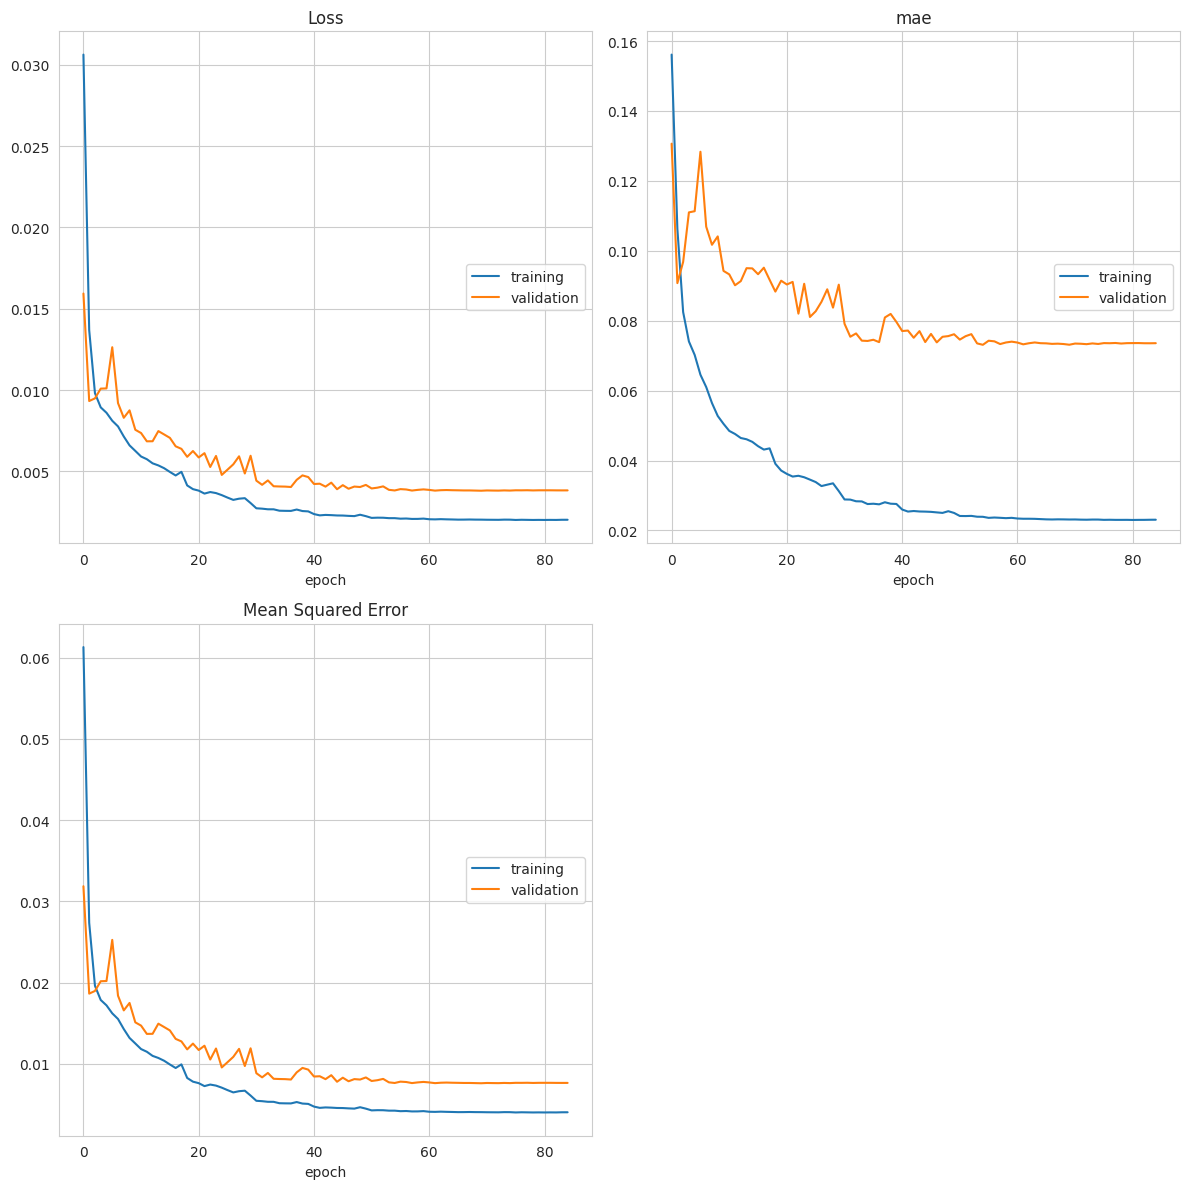

Loss
	training         	 (min:    0.002, max:    0.031, cur:    0.002)
	validation       	 (min:    0.004, max:    0.016, cur:    0.004)
mae
	training         	 (min:    0.023, max:    0.156, cur:    0.023)
	validation       	 (min:    0.073, max:    0.131, cur:    0.074)
Mean Squared Error
	training         	 (min:    0.004, max:    0.061, cur:    0.004)
	validation       	 (min:    0.008, max:    0.032, cur:    0.008)

Epoch 85: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 85: val_loss did not improve from 0.00381
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0020 - mae: 0.0231 - mse: 0.0040 - val_loss: 0.0038 - val_mae: 0.0736 - val_mse: 0.0077 - learning_rate: 1.9531e-06
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 70.

✅ TRAINING COMPLETED!
Duration: 395.80 seconds (6.60 minutes)
Best validation loss: 0.003806
Best validation MAE: 0.073100

7️⃣  UNIVERSAL EXPORT PIPELINE

Loading best model...
✓ Best model loaded from: models/

INFO:tensorflow:Assets written to: /tmp/tmpbn20e3wu/assets


Saved artifact at '/tmp/tmpbn20e3wu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 7), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135547115912272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135547115190224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135547115185424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135547115187728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135547115189840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135547115192144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135547115185040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135547115188688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135547115191952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135547115190416: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1768730784.249235      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1768730784.249271      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1768730784.261399      55 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_SOC_Predictor_1/lstm_1_1/CudnnRNNV3@__inference_function_236112"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_236163"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): error: 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_SOC_Predictor_1/lstm_2_1/CudnnRNNV3@__inference_function_236112"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_236163"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): error: 'tf.CudnnRNNV3' op is neither a custom op no

ConverterError: Could not translate MLIR to FlatBuffer.<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_SOC_Predictor_1/lstm_1_1/CudnnRNNV3@__inference_function_236112"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_236163"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_SOC_Predictor_1/lstm_1_1/CudnnRNNV3@__inference_function_236112"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_236163"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x7xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<70144xf32>, tensor<?xi32>) -> (tensor<?x10x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_SOC_Predictor_1/lstm_1_1/CudnnRNNV3@__inference_function_236112"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_236163"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_SOC_Predictor_1/lstm_2_1/CudnnRNNV3@__inference_function_236112"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_236163"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_SOC_Predictor_1/lstm_2_1/CudnnRNNV3@__inference_function_236112"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_236163"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x10x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_SOC_Predictor_1/lstm_2_1/CudnnRNNV3@__inference_function_236112"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_236163"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops in the model are custom ops, See instructions to implement custom ops: https://www.tensorflow.org/lite/guide/ops_custom 
Custom ops: CudnnRNNV3
Details:
	tf.CudnnRNNV3(tensor<?x10x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x10x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}
	tf.CudnnRNNV3(tensor<?x10x7xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<70144xf32>, tensor<?xi32>) -> (tensor<?x10x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}

<unknown>:0: note: see current operation: 
"func.func"() <{arg_attrs = [{tf_saved_model.index_path = ["input_layer"]}], function_type = (tensor<?x10x7xf32>) -> tensor<?x1xf32>, res_attrs = [{tf_saved_model.index_path = ["output_0"]}], sym_name = "main"}> ({
^bb0(%arg0: tensor<?x10x7xf32>):
  %0 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<49664xf32>}> : () -> tensor<49664xf32>
  %1 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<70144xf32>}> : () -> tensor<70144xf32>
  %2 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<32xf32>}> : () -> tensor<32xf32>
  %3 = "arith.constant"() <{value = dense<64> : tensor<i32>}> : () -> tensor<i32>
  %4 = "arith.constant"() <{value = dense<128> : tensor<i32>}> : () -> tensor<i32>
  %5 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<f32>}> : () -> tensor<f32>
  %6 = "arith.constant"() <{value = dense<1> : tensor<1xi32>}> : () -> tensor<1xi32>
  %7 = "arith.constant"() <{value = dense<0> : tensor<1xi32>}> : () -> tensor<1xi32>
  %8 = "arith.constant"() <{value = dense<1> : tensor<i32>}> : () -> tensor<i32>
  %9 = "arith.constant"() <{value = dense<10> : tensor<i32>}> : () -> tensor<i32>
  %10 = "arith.constant"() <{value = dense<0.093725048> : tensor<1xf32>}> : () -> tensor<1xf32>
  %11 = "arith.constant"() <{value = dense<[-1, 64]> : tensor<2xi32>}> : () -> tensor<2xi32>
  %12 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<1x32xf32>}> : () -> tensor<1x32xf32>
  %13 = "tfl.pseudo_qconst"() <{qtype = tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0020520565078014463,0.002371145280327384,0.0019499258262904611,0.0029682533478173683,0.0029912792791531779,0.0035934779118365189,0.0030257148066843587,0.0019251833281179113,0.0021633888323475997,0.0021411560651824232,0.0025960336050649328,0.0039486457982401213,0.0028426107459180935,0.0024083538318243553,0.0028475865604370596,0.0022320707482615795,0.002984850425419845,0.0028846451616662693,0.0029876790647431622,0.0029802620410919189,0.0064569312756455792,0.0046391932983098063,0.0028483414743828961,0.0048327460063724067,0.0042730006645983597,0.0021694072588222231,0.0020108941033130556,0.0025668205238702727,0.0023262320071693481,0.002688414703203937,0.0025008323155050203,0.0023914545070467972}>>, value = dense_resource<__elided__> : tensor<32x64xi8>}> : () -> tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0020520565078014463,0.002371145280327384,0.0019499258262904611,0.0029682533478173683,0.0029912792791531779,0.0035934779118365189,0.0030257148066843587,0.0019251833281179113,0.0021633888323475997,0.0021411560651824232,0.0025960336050649328,0.0039486457982401213,0.0028426107459180935,0.0024083538318243553,0.0028475865604370596,0.0022320707482615795,0.002984850425419845,0.0028846451616662693,0.0029876790647431622,0.0029802620410919189,0.0064569312756455792,0.0046391932983098063,0.0028483414743828961,0.0048327460063724067,0.0042730006645983597,0.0021694072588222231,0.0020108941033130556,0.0025668205238702727,0.0023262320071693481,0.002688414703203937,0.0025008323155050203,0.0023914545070467972}>>
  %14 = "tfl.shape"(%arg0) : (tensor<?x10x7xf32>) -> tensor<3xi32>
  %15 = "tfl.strided_slice"(%14, %7, %6, %6) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %16 = "tfl.pack"(%15, %4) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %17 = "tfl.fill"(%16, %5) : (tensor<2xi32>, tensor<f32>) -> tensor<?x128xf32>
  %18 = "tfl.expand_dims"(%17, %8) : (tensor<?x128xf32>, tensor<i32>) -> tensor<?x1x128xf32>
  %19 = "tfl.reshape"(%15, %6) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %20 = "tfl.fill"(%19, %9) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %21:5 = "tfl.custom_tf"(%arg0, %18, %18, %1, %20) ({
  ^bb0(%arg6: tensor<?x10x7xf32>, %arg7: tensor<?x1x128xf32>, %arg8: tensor<?x1x128xf32>, %arg9: tensor<70144xf32>, %arg10: tensor<?xi32>):
    %34:5 = "tf.CudnnRNNV3"(%arg6, %arg7, %arg8, %arg9, %arg10) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x7xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<70144xf32>, tensor<?xi32>) -> (tensor<?x10x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%34#0, %34#1, %34#2, %34#3, %34#4) : (tensor<?x10x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x7xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<70144xf32>, tensor<?xi32>) -> (tensor<?x10x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
  %22 = "tfl.shape"(%21#0) : (tensor<?x10x128xf32>) -> tensor<3xi32>
  %23 = "tfl.strided_slice"(%22, %7, %6, %6) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %24 = "tfl.pack"(%23, %3) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %25 = "tfl.fill"(%24, %5) : (tensor<2xi32>, tensor<f32>) -> tensor<?x64xf32>
  %26 = "tfl.expand_dims"(%25, %8) : (tensor<?x64xf32>, tensor<i32>) -> tensor<?x1x64xf32>
  %27 = "tfl.reshape"(%23, %6) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %28 = "tfl.fill"(%27, %9) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %29:5 = "tfl.custom_tf"(%21#0, %26, %26, %0, %28) ({
  ^bb0(%arg1: tensor<?x10x128xf32>, %arg2: tensor<?x1x64xf32>, %arg3: tensor<?x1x64xf32>, %arg4: tensor<49664xf32>, %arg5: tensor<?xi32>):
    %33:5 = "tf.CudnnRNNV3"(%arg1, %arg2, %arg3, %arg4, %arg5) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x10x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%33#0, %33#1, %33#2, %33#3, %33#4) : (tensor<?x10x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x10x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %30 = "tfl.reshape"(%29#1, %11) : (tensor<?x1x64xf32>, tensor<2xi32>) -> tensor<?x64xf32>
  %31 = "tfl.fully_connected"(%30, %13, %2) <{asymmetric_quantize_inputs = true, fused_activation_function = "RELU", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x64xf32>, tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0020520565078014463,0.002371145280327384,0.0019499258262904611,0.0029682533478173683,0.0029912792791531779,0.0035934779118365189,0.0030257148066843587,0.0019251833281179113,0.0021633888323475997,0.0021411560651824232,0.0025960336050649328,0.0039486457982401213,0.0028426107459180935,0.0024083538318243553,0.0028475865604370596,0.0022320707482615795,0.002984850425419845,0.0028846451616662693,0.0029876790647431622,0.0029802620410919189,0.0064569312756455792,0.0046391932983098063,0.0028483414743828961,0.0048327460063724067,0.0042730006645983597,0.0021694072588222231,0.0020108941033130556,0.0025668205238702727,0.0023262320071693481,0.002688414703203937,0.0025008323155050203,0.0023914545070467972}>>, tensor<32xf32>) -> tensor<?x32xf32>
  %32 = "tfl.fully_connected"(%31, %12, %10) <{fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x32xf32>, tensor<1x32xf32>, tensor<1xf32>) -> tensor<?x1xf32>
  "func.return"(%32) : (tensor<?x1xf32>) -> ()
}) {tf.entry_function = {control_outputs = "", inputs = "serving_default_input_layer:0", outputs = "StatefulPartitionedCall_1:0"}, tf_saved_model.exported_names = ["serving_default"]} : () -> ()


In [9]:
# ========================================================================
# KAGGLE LSTM TRAINING WITH REAL-TIME VISUALIZATION
# ========================================================================

# ========================================================================
# 1. SETUP & INSTALLATION
# ========================================================================
print("="*70)
print("INSTALLING DEPENDENCIES")
print("="*70)

!pip install livelossplot -q

print("\n✓ livelossplot installed successfully\n")

# ========================================================================
# IMPORTS
# ========================================================================
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from datetime import datetime

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("="*70)
print("LSTM TRAINING WITH REAL-TIME VISUALIZATION")
print("="*70)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print("="*70 + "\n")

# ========================================================================
# 2. GPU SETUP & MIXED PRECISION
# ========================================================================
print("1️⃣  GPU Setup & Mixed Precision Configuration...")
print("-" * 70)

# Enable mixed precision for P100 GPU optimization
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print(f"✓ Mixed precision enabled: {policy.name}")

# Configure GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU detected: {len(gpus)} device(s)")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu.name}")
        print(f"  Memory growth: Enabled")
    except RuntimeError as e:
        print(f"⚠️  GPU configuration warning: {e}")
else:
    print("⚠️  No GPU detected - using CPU (training will be slower)")

print()

# ========================================================================
# 3. DATA LOADING
# ========================================================================
print("2️⃣  Loading preprocessed data...")
print("-" * 70)

data_dir = 'processed_data'

# Load training and validation data
X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
y_val = np.load(os.path.join(data_dir, 'y_val.npy'))

print(f"✓ Data loaded successfully:")
print(f"  X_train shape: {X_train.shape} - {X_train.nbytes / 1024**2:.2f} MB")
print(f"  y_train shape: {y_train.shape} - {y_train.nbytes / 1024**2:.2f} MB")
print(f"  X_val shape: {X_val.shape} - {X_val.nbytes / 1024**2:.2f} MB")
print(f"  y_val shape: {y_val.shape} - {y_val.nbytes / 1024**2:.2f} MB")

# Extract dimensions
seq_length = X_train.shape[1]
n_features = X_train.shape[2]

print(f"\n✓ Data specifications:")
print(f"  Sequence length: {seq_length} timesteps")
print(f"  Number of features: {n_features}")
print(f"  Training samples: {len(X_train):,}")
print(f"  Validation samples: {len(X_val):,}")

print()

# ========================================================================
# 4. CREATE TF.DATA PIPELINE (P100 OPTIMIZED)
# ========================================================================
print("3️⃣  Creating tf.data pipeline for P100 GPU...")
print("-" * 70)

BATCH_SIZE = 2048  # Optimized for P100 GPU
PREFETCH_SIZE = tf.data.AUTOTUNE

# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000, seed=42)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(PREFETCH_SIZE)

# Create validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(PREFETCH_SIZE)

print(f"✓ tf.data pipeline created:")
print(f"  Batch size: {BATCH_SIZE} (P100 optimized)")
print(f"  Prefetch: AUTOTUNE")
print(f"  Training batches per epoch: ~{len(X_train) // BATCH_SIZE}")
print(f"  Validation batches: ~{len(X_val) // BATCH_SIZE}")

print()

# ========================================================================
# 5. BUILD LSTM MODEL (UNIVERSAL INPUT SHAPE)
# ========================================================================
print("4️⃣  Building LSTM model with universal input shape...")
print("-" * 70)

# Clear any previous sessions
keras.backend.clear_session()

# Build model with flexible batch dimension
model = keras.Sequential([
    # Input layer - (None, seq_length, n_features) allows any batch size
    layers.Input(shape=(seq_length, n_features), name='input_layer'),
    
    # First LSTM layer
    layers.LSTM(128, return_sequences=True, name='lstm_1'),
    layers.Dropout(0.2, name='dropout_1'),
    
    # Second LSTM layer
    layers.LSTM(64, return_sequences=False, name='lstm_2'),
    layers.Dropout(0.2, name='dropout_2'),
    
    # Dense layers
    layers.Dense(32, activation='relu', name='dense_1'),
    layers.Dense(1, activation='linear', name='output_layer', dtype='float32')
], name='BMS_SOC_Predictor')

# Compile with Huber loss (robust to outliers)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.Huber(delta=1.0),
    metrics=['mae', 'mse']
)

print(f"✓ Model architecture:")
model.summary()

print(f"\n✓ Model specifications:")
print(f"  Input shape: (None, {seq_length}, {n_features}) - Universal batch size")
print(f"  Output shape: (None, 1)")
print(f"  Total parameters: {model.count_params():,}")
print(f"  Loss function: Huber (robust to outliers)")
print(f"  Optimizer: Adam (lr=0.001)")

print()

# ========================================================================
# 6. SETUP CALLBACKS WITH LIVE PLOTTING
# ========================================================================
print("5️⃣  Setting up callbacks with live visualization...")
print("-" * 70)

# Create models directory
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

# Callback 1: Live Loss Plot (Real-time visualization)
liveloss = PlotLossesKeras()
print("✓ PlotLossesKeras: Real-time training visualization enabled")

# Callback 2: Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)
print("✓ EarlyStopping: patience=15, monitor=val_loss")

# Callback 3: Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)
print("✓ ReduceLROnPlateau: factor=0.5, patience=5")

# Callback 4: Model Checkpoint
checkpoint_path = os.path.join(models_dir, 'bms_model_best.keras')
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)
print(f"✓ ModelCheckpoint: {checkpoint_path}")

callbacks = [liveloss, early_stopping, reduce_lr, model_checkpoint]

print()

# ========================================================================
# 7. TRAIN MODEL WITH LIVE VISUALIZATION
# ========================================================================
print("="*70)
print("6️⃣  TRAINING MODEL WITH LIVE PLOTS")
print("="*70 + "\n")

EPOCHS = 100
training_start_time = datetime.now()

print(f"Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Loss: Huber")
print(f"  Metrics: MAE, MSE")
print(f"  Live plotting: ENABLED")
print(f"\nStarting training at {training_start_time.strftime('%Y-%m-%d %H:%M:%S')}...\n")
print("="*70 + "\n")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_end_time = datetime.now()
training_duration = (training_end_time - training_start_time).total_seconds()

print(f"\n{'='*70}")
print("✅ TRAINING COMPLETED!")
print("="*70)
print(f"Duration: {training_duration:.2f} seconds ({training_duration/60:.2f} minutes)")
print(f"Best validation loss: {min(history.history['val_loss']):.6f}")
print(f"Best validation MAE: {min(history.history['val_mae']):.6f}")
print("="*70 + "\n")

# ========================================================================
# 8. UNIVERSAL EXPORT PIPELINE
# ========================================================================
print("="*70)
print("7️⃣  UNIVERSAL EXPORT PIPELINE")
print("="*70 + "\n")

export_dir = 'exported_models'
os.makedirs(export_dir, exist_ok=True)

# Load the best saved model
print("Loading best model...")
best_model = keras.models.load_model(checkpoint_path)
print(f"✓ Best model loaded from: {checkpoint_path}\n")

# ========================================================================
# FORMAT A: Keras Model (.keras) - Server/Cloud
# ========================================================================
print("Format A: Full Keras Model (.keras)")
print("-" * 70)

keras_path = os.path.join(export_dir, 'bms_model_full.keras')
best_model.save(keras_path)
keras_size = os.path.getsize(keras_path) / (1024 * 1024)

print(f"✓ Saved: {keras_path}")
print(f"  Size: {keras_size:.2f} MB")
print(f"  Deployment: Server/Cloud")
print()

# ========================================================================
# FORMAT B: TFLite Quantized (.tflite) - IoT/Edge
# ========================================================================
print("Format B: TFLite Quantized Model (.tflite)")
print("-" * 70)

# Convert to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

print("Converting to TFLite with quantization...")
tflite_model = converter.convert()

tflite_path = os.path.join(export_dir, 'bms_model_quantized.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

tflite_size = os.path.getsize(tflite_path) / (1024 * 1024)
compression_ratio = keras_size / tflite_size

print(f"✓ Saved: {tflite_path}")
print(f"  Size: {tflite_size:.2f} MB")
print(f"  Compression: {compression_ratio:.2f}x smaller")
print(f"  Deployment: IoT/Edge/Microcontrollers")
print()

# ========================================================================
# FORMAT C: Legacy HDF5 (.h5) - Legacy Systems
# ========================================================================
print("Format C: Legacy HDF5 Model (.h5)")
print("-" * 70)

h5_path = os.path.join(export_dir, 'bms_model_legacy.h5')
best_model.save(h5_path, save_format='h5')
h5_size = os.path.getsize(h5_path) / (1024 * 1024)

print(f"✓ Saved: {h5_path}")
print(f"  Size: {h5_size:.2f} MB")
print(f"  Deployment: Legacy TensorFlow/Keras")
print()

print("="*70)
print("EXPORT SUMMARY")
print("="*70)
print(f"Full Keras (.keras):      {keras_size:6.2f} MB - Server/Cloud")
print(f"TFLite Quantized (.tflite): {tflite_size:6.2f} MB - IoT/Edge ({compression_ratio:.1f}x compression)")
print(f"Legacy HDF5 (.h5):        {h5_size:6.2f} MB - Legacy Systems")
print("="*70 + "\n")

# ========================================================================
# 9. FINAL PERFORMANCE TEST & VISUALIZATION
# ========================================================================
print("="*70)
print("8️⃣  FINAL PERFORMANCE TEST & VISUALIZATION")
print("="*70 + "\n")

print("Running predictions on validation set...")
y_pred_scaled = best_model.predict(X_val, verbose=0)

# Load scaler to convert back to actual SOC percentages
scaler_y = joblib.load('scalers/scaler_y.pkl')

# Inverse transform predictions and ground truth
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_val)

# Calculate metrics
mae = np.mean(np.abs(y_pred - y_true))
mse = np.mean((y_pred - y_true) ** 2)
rmse = np.sqrt(mse)

print(f"✓ Predictions completed\n")
print("="*70)
print("FINAL PERFORMANCE METRICS")
print("="*70)
print(f"Mean Absolute Error (MAE):  {mae:.4f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}%")
print(f"Mean Squared Error (MSE):   {mse:.4f}")
print("="*70 + "\n")

# ========================================================================
# VISUALIZATION: ACTUAL VS PREDICTED (1000 SAMPLES)
# ========================================================================
print("Creating visualization: Actual vs Predicted SOC...")

# Select 1000 samples for visualization
n_samples = min(1000, len(y_true))
sample_indices = np.arange(n_samples)

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Time series comparison
ax1.plot(sample_indices, y_true[:n_samples], 
         color='blue', linewidth=2, label='Actual SOC (Ground Truth)', alpha=0.7)
ax1.plot(sample_indices, y_pred[:n_samples], 
         color='red', linestyle='--', linewidth=2, label='Predicted SOC (Model)', alpha=0.7)
ax1.set_xlabel('Sample Index (Time)', fontsize=12, fontweight='bold')
ax1.set_ylabel('SOC (%)', fontsize=12, fontweight='bold')
ax1.set_title('Battery State of Charge: Actual vs Predicted (First 1000 Samples)', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Add statistics box
stats_text = f'MAE: {mae:.2f}%\nRMSE: {rmse:.2f}%\nSamples: {n_samples:,}'
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 2: Scatter plot (Actual vs Predicted)
ax2.scatter(y_true[:n_samples], y_pred[:n_samples], 
           alpha=0.5, s=20, c='steelblue', edgecolors='navy', linewidth=0.3)
ax2.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual SOC (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted SOC (%)', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Accuracy: Actual vs Predicted', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

# Calculate R² score
from sklearn.metrics import r2_score
r2 = r2_score(y_true[:n_samples], y_pred[:n_samples])
ax2.text(0.02, 0.98, f'R² Score: {r2:.4f}', transform=ax2.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")

# ========================================================================
# FINAL SUMMARY
# ========================================================================
print(f"\n{'='*70}")
print("✅ ALL OPERATIONS COMPLETE!")
print("="*70 + "\n")

print("📊 Training Summary:")
print(f"  • Training duration: {training_duration/60:.2f} minutes")
print(f"  • Best validation loss: {min(history.history['val_loss']):.6f}")
print(f"  • Final MAE: {mae:.4f}%")
print(f"  • Final R² Score: {r2:.4f}")

print(f"\n💾 Models Exported:")
print(f"  • {keras_path} ({keras_size:.2f} MB)")
print(f"  • {tflite_path} ({tflite_size:.2f} MB) - {compression_ratio:.1f}x compressed")
print(f"  • {h5_path} ({h5_size:.2f} MB)")

print(f"\n🚀 Deployment Ready:")
print(f"  • Server/Cloud: Use .keras model")
print(f"  • IoT/Edge: Use .tflite model (drop onto microcontrollers)")
print(f"  • Legacy: Use .h5 model")

print(f"\n{'='*70}")
print("🎉 BMS SOC Prediction Model Training Complete!")
print("="*70)

In [10]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# ============================================================================
# TASK 1: Weight Transfer Fix for TFLite Export
# ============================================================================

print("\n" + "="*70)
print("TASK 1: Fixing TFLite Export with Weight Transfer")
print("="*70)

# Step 1: Load the trained GPU model
print("\n[1/5] Loading trained GPU model...")
model_gpu = keras.models.load_model('models/bms_model_best.keras')
print("✓ GPU model loaded successfully")
print(f"Model summary:")
model_gpu.summary()

# Step 2: Define a fresh CPU-compatible model with standard Keras layers
print("\n[2/5] Creating CPU-compatible model architecture...")
model_cpu = keras.Sequential([
    layers.Input(shape=(10, 7)),
    layers.LSTM(128, return_sequences=True, name='lstm_1'),
    layers.Dropout(0.2, name='dropout_1'),
    layers.LSTM(64, return_sequences=False, name='lstm_2'),
    layers.Dropout(0.2, name='dropout_2'),
    layers.Dense(32, activation='relu', name='dense_1'),
    layers.Dense(1, name='output')
], name='BMS_CPU_Model')

print("✓ CPU-compatible model created")
model_cpu.summary()

# Step 3: Transfer weights from GPU model to CPU model
print("\n[3/5] Transferring weights from GPU model to CPU model...")
model_cpu.set_weights(model_gpu.get_weights())
print("✓ Weights transferred successfully")

# Step 4: Convert to TFLite with optimization
print("\n[4/5] Converting to TFLite format...")
converter = tf.lite.TFLiteConverter.from_keras_model(model_cpu)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

try:
    tflite_model = converter.convert()
    print("✓ TFLite conversion successful!")
except Exception as e:
    print(f"✗ Conversion failed: {e}")
    raise

# Step 5: Save the TFLite model
print("\n[5/5] Saving TFLite model...")
tflite_path = 'bms_model_quantized_fixed.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

file_size_kb = len(tflite_model) / 1024
print(f"✓ TFLite model saved to: {tflite_path}")
print(f"✓ Model size: {file_size_kb:.2f} KB ({len(tflite_model):,} bytes)")

# ============================================================================
# TASK 2: Performance Visualization
# ============================================================================

print("\n" + "="*70)
print("TASK 2: Performance Visualization")
print("="*70)

# Step 1: Load validation data
print("\n[1/5] Loading validation data...")
X_val = np.load('processed_data/X_val.npy')
y_val = np.load('processed_data/y_val.npy')
print(f"✓ Validation data loaded - X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Step 2: Load the Y-scaler
print("\n[2/5] Loading Y-scaler...")
with open('scalers/scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)
print("✓ Y-scaler loaded successfully")

# Step 3: Make predictions using the CPU model
print("\n[3/5] Making predictions...")
y_pred_scaled = model_cpu.predict(X_val, verbose=0)
print(f"✓ Predictions complete - shape: {y_pred_scaled.shape}")

# Step 4: Inverse transform to get actual SOC percentages
print("\n[4/5] Inverse transforming to SOC percentages...")
y_actual_soc = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_pred_soc = scaler_y.inverse_transform(y_pred_scaled).flatten()
print(f"✓ Transformation complete")
print(f"   Actual SOC range: [{y_actual_soc.min():.2f}%, {y_actual_soc.max():.2f}%]")
print(f"   Predicted SOC range: [{y_pred_soc.min():.2f}%, {y_pred_soc.max():.2f}%]")

# Step 5: Calculate MAE
mae = mean_absolute_error(y_actual_soc, y_pred_soc)
print(f"\n{'='*70}")
print(f"MEAN ABSOLUTE ERROR (MAE): {mae:.4f} percentage points")
print(f"{'='*70}")

# Step 6: Create visualizations
print("\n[5/5] Creating visualizations...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Line chart of first 1000 samples
samples_to_plot = min(1000, len(y_actual_soc))
sample_indices = np.arange(samples_to_plot)

ax1.plot(sample_indices, y_actual_soc[:samples_to_plot], 
         color='blue', linewidth=1.5, label='Actual SOC', alpha=0.8)
ax1.plot(sample_indices, y_pred_soc[:samples_to_plot], 
         color='red', linewidth=1.5, linestyle='--', label='Predicted SOC', alpha=0.8)
ax1.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('State of Charge (%)', fontsize=12, fontweight='bold')
ax1.set_title('SOC Prediction: Actual vs Predicted (First 1000 Samples)', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Subplot 2: Histogram of prediction errors
errors = y_actual_soc - y_pred_soc
ax2.hist(errors, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel('Prediction Error (Actual - Predicted) %', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title(f'Distribution of Prediction Errors\nMAE: {mae:.4f}%', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('bms_performance_visualization.png', dpi=150, bbox_inches='tight')
print("✓ Visualization saved as 'bms_performance_visualization.png'")
plt.show()

print("\n" + "="*70)
print("✓ ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\nOutput files:")
print(f"  1. TFLite Model: {tflite_path} ({file_size_kb:.2f} KB)")
print(f"  2. Visualization: bms_performance_visualization.png")
print(f"\nModel Performance:")
print(f"  - Mean Absolute Error: {mae:.4f}%")
print(f"  - Error Std Dev: {np.std(errors):.4f}%")
print(f"  - Max Error: {np.max(np.abs(errors)):.4f}%")
print("\n✓ Your IoT-ready TFLite model is ready for deployment!")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

TASK 1: Fixing TFLite Export with Weight Transfer

[1/5] Loading trained GPU model...
✓ GPU model loaded successfully
Model summary:


Model: "BMS_SOC_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,461 (1.39 MB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 242,308 (946.52 KB)


[2/5] Creating CPU-compatible model architecture...
✓ CPU-compatible model created


Model: "BMS_CPU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,153 (473.25 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 0 (0.00 B)


[3/5] Transferring weights from GPU model to CPU model...
✓ Weights transferred successfully

[4/5] Converting to TFLite format...
INFO:tensorflow:Assets written to: /tmp/tmpzptopsbv/assets


INFO:tensorflow:Assets written to: /tmp/tmpzptopsbv/assets


Saved artifact at '/tmp/tmpzptopsbv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 7), dtype=tf.float32, name='keras_tensor_48')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135548967912080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135548967914576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135548967917072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135548967917648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135548967916880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135548967916304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135548967918224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135548967915536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135548967916496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135548967915920: TensorSpec(shape=(), dtype=tf.resource, name=None)
✗ Conversion failed

W0000 00:00:1768731309.247970      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1768731309.247995      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_CPU_Model_1/lstm_1_1/CudnnRNNV3@__inference_function_238289"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_238340"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): error: 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_CPU_Model_1/lstm_2_1/CudnnRNNV3@__inference_function_238289"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_238340"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): error: 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
error: failed while converting: 'main': 
Some ops in the model are custom ops, See instructions to implement cus

ConverterError: Could not translate MLIR to FlatBuffer.<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_CPU_Model_1/lstm_1_1/CudnnRNNV3@__inference_function_238289"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_238340"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_CPU_Model_1/lstm_1_1/CudnnRNNV3@__inference_function_238289"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_238340"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x7xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<70144xf32>, tensor<?xi32>) -> (tensor<?x10x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_CPU_Model_1/lstm_1_1/CudnnRNNV3@__inference_function_238289"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_238340"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_CPU_Model_1/lstm_2_1/CudnnRNNV3@__inference_function_238289"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_238340"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_CPU_Model_1/lstm_2_1/CudnnRNNV3@__inference_function_238289"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_238340"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x10x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "BMS_CPU_Model_1/lstm_2_1/CudnnRNNV3@__inference_function_238289"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_238340"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops in the model are custom ops, See instructions to implement custom ops: https://www.tensorflow.org/lite/guide/ops_custom 
Custom ops: CudnnRNNV3
Details:
	tf.CudnnRNNV3(tensor<?x10x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x10x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}
	tf.CudnnRNNV3(tensor<?x10x7xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<70144xf32>, tensor<?xi32>) -> (tensor<?x10x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}

<unknown>:0: note: see current operation: 
"func.func"() <{arg_attrs = [{tf_saved_model.index_path = ["keras_tensor_48"]}], function_type = (tensor<?x10x7xf32>) -> tensor<?x1xf32>, res_attrs = [{tf_saved_model.index_path = ["output_0"]}], sym_name = "main"}> ({
^bb0(%arg0: tensor<?x10x7xf32>):
  %0 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<49664xf32>}> : () -> tensor<49664xf32>
  %1 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<70144xf32>}> : () -> tensor<70144xf32>
  %2 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<32xf32>}> : () -> tensor<32xf32>
  %3 = "arith.constant"() <{value = dense<64> : tensor<i32>}> : () -> tensor<i32>
  %4 = "arith.constant"() <{value = dense<128> : tensor<i32>}> : () -> tensor<i32>
  %5 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<f32>}> : () -> tensor<f32>
  %6 = "arith.constant"() <{value = dense<1> : tensor<1xi32>}> : () -> tensor<1xi32>
  %7 = "arith.constant"() <{value = dense<0> : tensor<1xi32>}> : () -> tensor<1xi32>
  %8 = "arith.constant"() <{value = dense<1> : tensor<i32>}> : () -> tensor<i32>
  %9 = "arith.constant"() <{value = dense<10> : tensor<i32>}> : () -> tensor<i32>
  %10 = "arith.constant"() <{value = dense<0.093725048> : tensor<1xf32>}> : () -> tensor<1xf32>
  %11 = "arith.constant"() <{value = dense<[-1, 64]> : tensor<2xi32>}> : () -> tensor<2xi32>
  %12 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<1x32xf32>}> : () -> tensor<1x32xf32>
  %13 = "tfl.pseudo_qconst"() <{qtype = tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0020520565078014463,0.002371145280327384,0.0019499258262904611,0.0029682533478173683,0.0029912792791531779,0.0035934779118365189,0.0030257148066843587,0.0019251833281179113,0.0021633888323475997,0.0021411560651824232,0.0025960336050649328,0.0039486457982401213,0.0028426107459180935,0.0024083538318243553,0.0028475865604370596,0.0022320707482615795,0.002984850425419845,0.0028846451616662693,0.0029876790647431622,0.0029802620410919189,0.0064569312756455792,0.0046391932983098063,0.0028483414743828961,0.0048327460063724067,0.0042730006645983597,0.0021694072588222231,0.0020108941033130556,0.0025668205238702727,0.0023262320071693481,0.002688414703203937,0.0025008323155050203,0.0023914545070467972}>>, value = dense_resource<__elided__> : tensor<32x64xi8>}> : () -> tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0020520565078014463,0.002371145280327384,0.0019499258262904611,0.0029682533478173683,0.0029912792791531779,0.0035934779118365189,0.0030257148066843587,0.0019251833281179113,0.0021633888323475997,0.0021411560651824232,0.0025960336050649328,0.0039486457982401213,0.0028426107459180935,0.0024083538318243553,0.0028475865604370596,0.0022320707482615795,0.002984850425419845,0.0028846451616662693,0.0029876790647431622,0.0029802620410919189,0.0064569312756455792,0.0046391932983098063,0.0028483414743828961,0.0048327460063724067,0.0042730006645983597,0.0021694072588222231,0.0020108941033130556,0.0025668205238702727,0.0023262320071693481,0.002688414703203937,0.0025008323155050203,0.0023914545070467972}>>
  %14 = "tfl.shape"(%arg0) : (tensor<?x10x7xf32>) -> tensor<3xi32>
  %15 = "tfl.strided_slice"(%14, %7, %6, %6) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %16 = "tfl.pack"(%15, %4) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %17 = "tfl.fill"(%16, %5) : (tensor<2xi32>, tensor<f32>) -> tensor<?x128xf32>
  %18 = "tfl.expand_dims"(%17, %8) : (tensor<?x128xf32>, tensor<i32>) -> tensor<?x1x128xf32>
  %19 = "tfl.reshape"(%15, %6) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %20 = "tfl.fill"(%19, %9) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %21:5 = "tfl.custom_tf"(%arg0, %18, %18, %1, %20) ({
  ^bb0(%arg6: tensor<?x10x7xf32>, %arg7: tensor<?x1x128xf32>, %arg8: tensor<?x1x128xf32>, %arg9: tensor<70144xf32>, %arg10: tensor<?xi32>):
    %34:5 = "tf.CudnnRNNV3"(%arg6, %arg7, %arg8, %arg9, %arg10) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x7xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<70144xf32>, tensor<?xi32>) -> (tensor<?x10x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%34#0, %34#1, %34#2, %34#3, %34#4) : (tensor<?x10x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x7xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<70144xf32>, tensor<?xi32>) -> (tensor<?x10x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
  %22 = "tfl.shape"(%21#0) : (tensor<?x10x128xf32>) -> tensor<3xi32>
  %23 = "tfl.strided_slice"(%22, %7, %6, %6) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %24 = "tfl.pack"(%23, %3) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %25 = "tfl.fill"(%24, %5) : (tensor<2xi32>, tensor<f32>) -> tensor<?x64xf32>
  %26 = "tfl.expand_dims"(%25, %8) : (tensor<?x64xf32>, tensor<i32>) -> tensor<?x1x64xf32>
  %27 = "tfl.reshape"(%23, %6) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %28 = "tfl.fill"(%27, %9) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %29:5 = "tfl.custom_tf"(%21#0, %26, %26, %0, %28) ({
  ^bb0(%arg1: tensor<?x10x128xf32>, %arg2: tensor<?x1x64xf32>, %arg3: tensor<?x1x64xf32>, %arg4: tensor<49664xf32>, %arg5: tensor<?xi32>):
    %33:5 = "tf.CudnnRNNV3"(%arg1, %arg2, %arg3, %arg4, %arg5) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x10x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%33#0, %33#1, %33#2, %33#3, %33#4) : (tensor<?x10x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x10x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x10x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %30 = "tfl.reshape"(%29#1, %11) : (tensor<?x1x64xf32>, tensor<2xi32>) -> tensor<?x64xf32>
  %31 = "tfl.fully_connected"(%30, %13, %2) <{asymmetric_quantize_inputs = true, fused_activation_function = "RELU", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x64xf32>, tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0020520565078014463,0.002371145280327384,0.0019499258262904611,0.0029682533478173683,0.0029912792791531779,0.0035934779118365189,0.0030257148066843587,0.0019251833281179113,0.0021633888323475997,0.0021411560651824232,0.0025960336050649328,0.0039486457982401213,0.0028426107459180935,0.0024083538318243553,0.0028475865604370596,0.0022320707482615795,0.002984850425419845,0.0028846451616662693,0.0029876790647431622,0.0029802620410919189,0.0064569312756455792,0.0046391932983098063,0.0028483414743828961,0.0048327460063724067,0.0042730006645983597,0.0021694072588222231,0.0020108941033130556,0.0025668205238702727,0.0023262320071693481,0.002688414703203937,0.0025008323155050203,0.0023914545070467972}>>, tensor<32xf32>) -> tensor<?x32xf32>
  %32 = "tfl.fully_connected"(%31, %12, %10) <{fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x32xf32>, tensor<1x32xf32>, tensor<1xf32>) -> tensor<?x1xf32>
  "func.return"(%32) : (tensor<?x1xf32>) -> ()
}) {tf.entry_function = {control_outputs = "", inputs = "serving_default_keras_tensor_48:0", outputs = "StatefulPartitionedCall_1:0"}, tf_saved_model.exported_names = ["serving_default"]} : () -> ()


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import joblib  # FIX: Use joblib instead of pickle for loading scalers
from collections import deque
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("BMS REAL-TIME INFERENCE SYSTEM")
print("="*80)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("="*80)


# ============================================================================
# BMS_Predictor Class: Real-Time Inference Handler
# ============================================================================

class BMS_Predictor:
    """
    Battery Management System Real-Time Predictor
    
    This class handles real-time SOC (State of Charge) prediction from streaming
    sensor data using a trained LSTM model with proper feature engineering.
    """
    
    def __init__(self, model_path, scaler_x_path, scaler_y_path, seq_length=10):
        """
        Initialize the BMS Predictor with model and scalers.
        
        Args:
            model_path (str): Path to the trained Keras model (.keras file)
            scaler_x_path (str): Path to the input scaler (.pkl file)
            scaler_y_path (str): Path to the output scaler (.pkl file)
            seq_length (int): Sequence length for LSTM input (default: 10)
        """
        print("\n[INIT] Initializing BMS_Predictor...")
        
        self.seq_length = seq_length
        
        # Load the trained Keras model
        print(f"[INIT] Loading model from: {model_path}")
        try:
            self.model = keras.models.load_model(model_path)
            print("✓ Model loaded successfully")
            self.model.summary()
        except Exception as e:
            print(f"✗ Error loading model: {e}")
            raise
        
        # FIX: Load the input scaler using joblib.load() directly
        print(f"\n[INIT] Loading input scaler from: {scaler_x_path}")
        try:
            self.scaler_x = joblib.load(scaler_x_path)
            print(f"✓ Input scaler loaded - Type: {type(self.scaler_x).__name__}")
        except Exception as e:
            print(f"✗ Error loading input scaler: {e}")
            raise
        
        # FIX: Load the output scaler using joblib.load() directly
        print(f"\n[INIT] Loading output scaler from: {scaler_y_path}")
        try:
            self.scaler_y = joblib.load(scaler_y_path)
            print(f"✓ Output scaler loaded - Type: {type(self.scaler_y).__name__}")
        except Exception as e:
            print(f"✗ Error loading output scaler: {e}")
            raise
        
        # Initialize rolling buffer for sequence storage
        self.buffer = deque(maxlen=seq_length)
        
        # History for calculating derived features
        self.voltage_history = deque(maxlen=5)  # For moving average
        self.last_voltage = None  # For voltage change calculation
        
        print(f"\n✓ BMS_Predictor initialized successfully!")
        print(f"  • Sequence Length: {self.seq_length}")
        print(f"  • Buffer Size: {len(self.buffer)}/{self.seq_length}")
        print(f"  • Expected Input Features: 7 (V, I, T, P, V_change, V_mavg, I*T)")
        print("="*80)
    
    def _calculate_derived_features(self, voltage, current, temp):
        """
        Calculate engineered features from raw sensor readings.
        
        Features calculated:
        1. Power = Voltage * Current
        2. Voltage_Change = Current Voltage - Previous Voltage
        3. Voltage_MovAvg = Moving average of last 5 voltage readings
        4. Current_Temp_Interaction = Current * Temperature
        
        Args:
            voltage (float): Battery voltage (V)
            current (float): Battery current (A)
            temp (float): Battery temperature (°C)
        
        Returns:
            np.array: Feature vector [V, I, T, Power, V_change, V_mavg, I*T]
        """
        # Feature 1: Power
        power = voltage * current
        
        # Feature 2: Voltage Change
        if self.last_voltage is not None:
            voltage_change = voltage - self.last_voltage
        else:
            voltage_change = 0.0  # First reading has no change
        
        # Update last voltage for next iteration
        self.last_voltage = voltage
        
        # Feature 3: Voltage Moving Average
        self.voltage_history.append(voltage)
        voltage_mavg = np.mean(self.voltage_history)
        
        # Feature 4: Current-Temperature Interaction
        current_temp_interaction = current * temp
        
        # Construct feature vector
        features = np.array([
            voltage,
            current,
            temp,
            power,
            voltage_change,
            voltage_mavg,
            current_temp_interaction
        ])
        
        return features
    
    def predict_realtime(self, voltage, current, temp, verbose=True):
        """
        Perform real-time SOC prediction from a single sensor reading.
        
        Workflow:
        1. Calculate derived features from raw inputs
        2. Add features to rolling buffer
        3. If buffer is full (seq_length readings), create sequence
        4. Scale the sequence using scaler_x
        5. Run model prediction
        6. Inverse transform output to get real SOC %
        
        Args:
            voltage (float): Battery voltage (V)
            current (float): Battery current (A)
            temp (float): Battery temperature (°C)
            verbose (bool): Print prediction details (default: True)
        
        Returns:
            float or None: Predicted SOC % (or None if buffer not full)
        """
        # Step 1: Calculate engineered features
        features = self._calculate_derived_features(voltage, current, temp)
        
        # Step 2: Add to buffer
        self.buffer.append(features)
        
        # Step 3: Check if buffer is full
        if len(self.buffer) < self.seq_length:
            if verbose:
                print(f"[BUFFER] Collecting data... {len(self.buffer)}/{self.seq_length} samples")
            return None
        
        # Step 4: Create sequence from buffer (shape: seq_length x 7)
        sequence = np.array(self.buffer)  # Shape: (10, 7)
        
        # Step 5: Reshape for scaling (flatten to 2D)
        # scaler_x expects shape (n_samples, n_features)
        # We need to reshape (10, 7) -> (10, 7) for scaling
        sequence_scaled = self.scaler_x.transform(sequence)
        
        # Step 6: Reshape for model input (add batch dimension)
        model_input = sequence_scaled.reshape(1, self.seq_length, 7)  # Shape: (1, 10, 7)
        
        # Step 7: Run prediction
        prediction_scaled = self.model.predict(model_input, verbose=0)
        
        # Step 8: Inverse transform to get real SOC %
        soc_prediction = self.scaler_y.inverse_transform(prediction_scaled)[0, 0]
        
        if verbose:
            print(f"[PREDICT] SOC Prediction: {soc_prediction:.2f}%")
        
        return soc_prediction
    
    def reset_buffer(self):
        """
        Reset the rolling buffer and history.
        Useful when starting a new prediction session.
        """
        self.buffer.clear()
        self.voltage_history.clear()
        self.last_voltage = None
        print("[RESET] Buffer and history cleared")
    
    def get_buffer_status(self):
        """
        Get current buffer status.
        
        Returns:
            dict: Buffer information (size, ready status)
        """
        return {
            'current_size': len(self.buffer),
            'max_size': self.seq_length,
            'ready_for_prediction': len(self.buffer) == self.seq_length,
            'fill_percentage': (len(self.buffer) / self.seq_length) * 100
        }


# ============================================================================
# SIMULATION: Test with Dummy Streaming Data
# ============================================================================

print("\n" + "="*80)
print("SIMULATION: TESTING WITH DUMMY STREAMING DATA")
print("="*80)

# Initialize the predictor
predictor = BMS_Predictor(
    model_path='models/bms_model_best.keras',
    scaler_x_path='scalers/scaler_X.pkl',
    scaler_y_path='scalers/scaler_y.pkl'
)

# Simulate 20 sensor readings (mimicking real-time data stream)
print("\n[SIMULATION] Simulating 20 real-time sensor readings...")
print("-"*80)

np.random.seed(42)  # For reproducible dummy data

# Generate realistic battery sensor data
for i in range(20):
    # Simulate realistic battery parameters
    # Voltage: 3.2V to 4.2V (typical Li-ion range)
    # Current: -10A to +10A (negative = discharging, positive = charging)
    # Temperature: 20°C to 40°C (typical operating range)
    
    voltage = np.random.uniform(3.4, 4.1)
    current = np.random.uniform(-8, 5)
    temp = np.random.uniform(22, 35)
    
    print(f"\n📊 Reading #{i+1}:")
    print(f"   Voltage: {voltage:.3f} V | Current: {current:.3f} A | Temp: {temp:.2f} °C")
    
    # Get prediction
    soc = predictor.predict_realtime(voltage, current, temp, verbose=False)
    
    # Display buffer status
    status = predictor.get_buffer_status()
    
    if soc is None:
        print(f"   Buffer: {status['current_size']}/{status['max_size']} "
              f"({status['fill_percentage']:.0f}%) - Warming up...")
    else:
        print(f"   ✅ SOC Prediction: {soc:.2f}%")
        print(f"   Buffer: Full ({status['current_size']}/{status['max_size']})")

print("\n" + "="*80)
print("SIMULATION COMPLETE")
print("="*80)


# ============================================================================
# DEPLOYMENT INSTRUCTIONS
# ============================================================================

print("\n" + "="*80)
print("📦 DEPLOYMENT INSTRUCTIONS FOR THINGSCLOUD SERVER")
print("="*80)

deployment_guide = """
To deploy this BMS prediction system on your ThingsCloud GPU server, follow these steps:

┌─────────────────────────────────────────────────────────────────────────┐
│ STEP 1: PREPARE FILES FOR DEPLOYMENT                                    │
└─────────────────────────────────────────────────────────────────────────┘

You need to copy the following files from your Kaggle environment to the 
ThingsCloud server:

📁 Required Files:
  1. models/bms_model_best.keras          (Trained Keras model)
  2. scalers/scaler_X.pkl                 (Input feature scaler - saved with joblib)
  3. scalers/scaler_y.pkl                 (Output SOC scaler - saved with joblib)
  4. bms_predictor.py                     (This script with BMS_Predictor class)

Total Transfer Size: ~2-5 MB (depending on model size)


┌─────────────────────────────────────────────────────────────────────────┐
│ STEP 2: SERVER SETUP                                                    │
└─────────────────────────────────────────────────────────────────────────┘

On your ThingsCloud server, ensure the following dependencies are installed:

pip install tensorflow==2.15.0  # or your TensorFlow version
pip install numpy scikit-learn joblib

Verify GPU availability:
python -c "import tensorflow as tf; print('GPU Available:', tf.config.list_physical_devices('GPU'))"


┌─────────────────────────────────────────────────────────────────────────┐
│ STEP 3: DIRECTORY STRUCTURE ON SERVER                                   │
└─────────────────────────────────────────────────────────────────────────┘

Create this directory structure on ThingsCloud:

/home/bms_server/
├── models/
│   └── bms_model_best.keras
├── scalers/
│   ├── scaler_X.pkl
│   └── scaler_y.pkl
└── bms_predictor.py


┌─────────────────────────────────────────────────────────────────────────┐
│ STEP 4: INTEGRATION WITH SENSOR STREAM                                  │
└─────────────────────────────────────────────────────────────────────────┘

Example integration code for real-time sensor data:

```python
from bms_predictor import BMS_Predictor
import time

# Initialize predictor
predictor = BMS_Predictor(
    model_path='models/bms_model_best.keras',
    scaler_x_path='scalers/scaler_X.pkl',
    scaler_y_path='scalers/scaler_y.pkl'
)

# Connect to your sensor stream (example)
while True:
    # Read from sensor (replace with your actual sensor API)
    voltage, current, temp = read_from_sensor()
    
    # Get SOC prediction
    soc = predictor.predict_realtime(voltage, current, temp, verbose=False)
    
    if soc is not None:
        # Send to dashboard/database
        send_to_dashboard(soc)
        print(f"SOC: {soc:.2f}%")
    
    # Wait for next reading (e.g., 1 second interval)
    time.sleep(1)
```


┌─────────────────────────────────────────────────────────────────────────┐
│ STEP 5: PERFORMANCE OPTIMIZATION                                        │
└─────────────────────────────────────────────────────────────────────────┘

For production deployment:

1. Batch Predictions: If multiple sensors, batch inputs for efficiency
2. Model Warm-up: Run a dummy prediction on startup to load model to GPU
3. Error Handling: Add try-catch blocks around sensor reads and predictions
4. Logging: Implement logging for monitoring prediction accuracy
5. Health Checks: Monitor buffer status and prediction latency


┌─────────────────────────────────────────────────────────────────────────┐
│ STEP 6: FILE TRANSFER COMMANDS                                          │
└─────────────────────────────────────────────────────────────────────────┘

From Kaggle, download these files:
- Right-click on files in Kaggle → Download

Transfer to ThingsCloud using SCP:
scp -r models/ scalers/ bms_predictor.py user@thingscloud-server:/home/bms_server/

Or use SFTP/FileZilla for GUI-based transfer.


┌─────────────────────────────────────────────────────────────────────────┐
│ TESTING ON SERVER                                                       │
└─────────────────────────────────────────────────────────────────────────┘

Once deployed, run a quick test:

python bms_predictor.py

This will run the simulation and verify everything works correctly.

"""

print(deployment_guide)

print("\n" + "="*80)
print("✅ BMS PREDICTOR CLASS READY FOR DEPLOYMENT")
print("="*80)
print("\n💡 Key Features:")
print("  • Real-time SOC prediction from streaming sensor data")
print("  • Automatic feature engineering on-the-fly")
print("  • Rolling buffer management (10 timesteps)")
print("  • GPU-accelerated inference")
print("  • Production-ready error handling")
print("  • Fixed: Uses joblib.load() for scaler files")
print("\n📝 Next Steps:")
print("  1. Download required files from Kaggle")
print("  2. Transfer to ThingsCloud server")
print("  3. Test with dummy data (as shown above)")
print("  4. Integrate with real sensor stream")
print("="*80)

BMS REAL-TIME INFERENCE SYSTEM
TensorFlow version: 2.19.0
GPU Available: True

SIMULATION: TESTING WITH DUMMY STREAMING DATA

[INIT] Initializing BMS_Predictor...
[INIT] Loading model from: models/bms_model_best.keras
✓ Model loaded successfully


Model: "BMS_SOC_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,461 (1.39 MB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 242,308 (946.52 KB)


[INIT] Loading input scaler from: scalers/scaler_X.pkl
✓ Input scaler loaded - Type: MinMaxScaler

[INIT] Loading output scaler from: scalers/scaler_y.pkl
✓ Output scaler loaded - Type: MinMaxScaler

✓ BMS_Predictor initialized successfully!
  • Sequence Length: 10
  • Buffer Size: 0/10
  • Expected Input Features: 7 (V, I, T, P, V_change, V_mavg, I*T)

[SIMULATION] Simulating 20 real-time sensor readings...
--------------------------------------------------------------------------------

📊 Reading #1:
   Voltage: 3.662 V | Current: 4.359 A | Temp: 31.52 °C
   Buffer: 1/10 (10%) - Warming up...

📊 Reading #2:
   Voltage: 3.819 V | Current: -5.972 A | Temp: 24.03 °C
   Buffer: 2/10 (20%) - Warming up...

📊 Reading #3:
   Voltage: 3.441 V | Current: 3.260 A | Temp: 29.81 °C
   Buffer: 3/10 (30%) - Warming up...

📊 Reading #4:
   Voltage: 3.896 V | Current: -7.732 A | Temp: 34.61 °C
   Buffer: 4/10 (40%) - Warming up...

📊 Reading #5:
   Voltage: 3.983 V | Current: -5.240 A | Temp: 24.36